# This notebook sets an absorption line, which we will reproduce with forward modeling

Simple proof of concept modeling.

We want to predict the metallicity of a system by assuming that gas is distributed along all of line of sight assuming some radial profile. And from that teasing out the metallicity.

Written By:  Rongmon Bordoloi
             Feb 22, 2019
             
Modified by: P. Torrey continuously thereafter

Tested on: Python 3.7



In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from importlib import reload

from rbvfit import model as m
reload(m)

import emcee
import corner
import scipy.optimize as op
import sys

width = 30    # for plotting formatting...

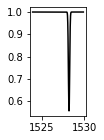

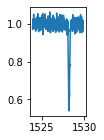

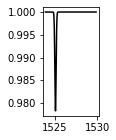

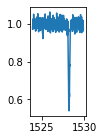

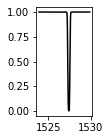

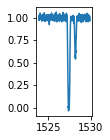

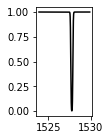

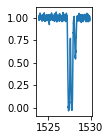

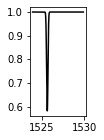

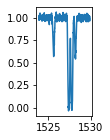

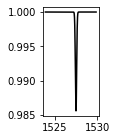

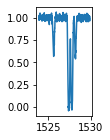

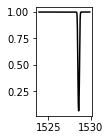

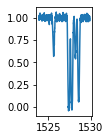

redoing this cloud!
redoing this cloud!


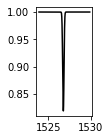

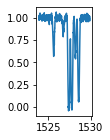

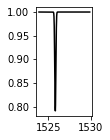

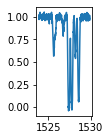

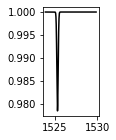

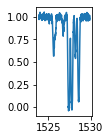

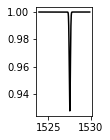

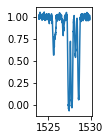

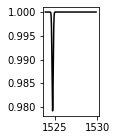

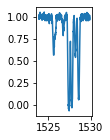

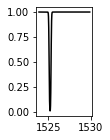

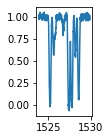

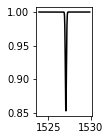

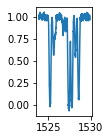

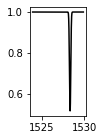

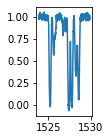

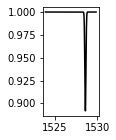

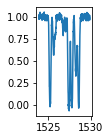

redoing this cloud!
redoing this cloud!
redoing this cloud!


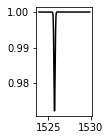

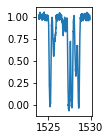

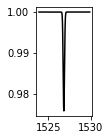

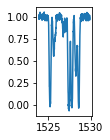

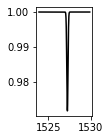

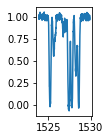

redoing this cloud!


In [43]:
#wave=np.arange(1526.,1528.,0.01)
wave=np.arange(1526.9 - 3.0,1526.9 + 3.0,0.01)
outflux = np.ones_like( wave )
outflux = outflux + np.random.normal(0., .02, len(wave))

n_clouds = 1
zabs     = np.zeros((n_clouds))
lambda_rest = 1526.9 * np.ones((n_clouds))

for this_cloud in range(25):
    logN=np.array([12.]) + np.random.uniform( 0, 3.0 )
    b=np.array([15.])    + np.random.uniform( 0, 5.0 )
    v=np.array([0.])     + np.random.uniform( -400, 400 )

    
    s=m.create_voigt(zabs,lambda_rest)
    theta=np.concatenate((logN,b,v))
    
    new_outflux = outflux + (s.model_flux(theta,wave) - 1.0) 
    if np.min(new_outflux) > -0.1:
        fig, ax = plt.subplots(figsize=(1, 2))
        plt.plot( wave, s.model_flux(theta,wave), c='k' )
        plt.show() 
        
        
        fig, ax = plt.subplots(figsize=(1, 2))
        outflux = new_outflux
        plt.plot( wave, outflux )
        plt.show()

    else:
        this_cloud -= 1
        print("redoing this cloud!")
 

# Add error
#fnorm= outflux + np.random.normal(0., .02, len(wave))
#enorm= 0.02 * np.ones((len(wave),))

#plt.step(wave,fnorm)
#plt.ylim([0.,1.2])

In [44]:
# looks like this step is just adding clouds to make a complicated absorption spectra, working backwards if you will

# Make a first, basic, single component test profile


(0.0, 1.2)

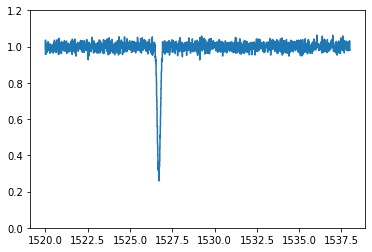

In [45]:
#wave=np.arange(1526.,1528.,0.01)
wave=np.arange(1520.,1538.,0.01)

n_clouds = 1
logN=np.array([14.])
b=np.array([20.])
v=np.array([0.])

zabs     = np.zeros((n_clouds))
lambda_rest = 1526.9 * np.ones((n_clouds))

s=m.create_voigt(zabs,lambda_rest)
theta=np.concatenate((logN,b,v))
outflux= s.model_flux(theta,wave)

orig_values = np.array([ logN, b, v ])

# Add error
fnorm= outflux + np.random.normal(0., .02, len(wave))
enorm= 0.02 * np.ones((len(wave),))

plt.step(wave,fnorm)
plt.ylim([0.,1.2])

# Setup Model for line properties

In [46]:
#los=np.arange(-100.,100.,1)
#def estimate_parameter_single_cell(log_rho, log_los_cm, log_solar, log_f_c, vel_p, log_temp):
def estimate_parameter_single_cell(log_rho, log_los_cm, vel_p, log_temp):
    # Convert the number density to actual ion number density 
    # Set metallicity
    O_H_Solar    = 10.**(-3.31);
    C_H_Solar    = 10.**(-3.61);
    Ne_H_Solar   = 10.**(-4.00);
    N_H_Solar    = 10.**(-4.07);
    Si_H_Solar   = 10.**(-4.46);
    Mg_H_Solar   = 10.**(-4.46);
    
    KBOLTZMANN = 1.3806488e-16;
    
    # Atomic Mass unit, grams.
    AMU          = 1.6605388*10.**(-24.);
    kmpsToCmps   = 1.0*10.**(5.);
    oxygenMass   = 15.999 * AMU;
    carbonMass   =  6.000 * AMU;
    neonMass     = 10.000 * AMU;
    nitrogenMass = 7.000 * AMU;
    silliconMass = 14.00 * AMU;
    magnesiumMass= 12.00 *AMU; 
    
    X_mass= silliconMass
    X_H_Solar= Si_H_Solar

    # Compute b assuming it is thermal at temperature Temp
    b = np.ones_like(log_rho)*(1.0*10.**(-5.)*np.sqrt(2.0 *KBOLTZMANN * 10.0**log_temp / X_mass))

    metallicity = 10.0**(0.0)*X_H_Solar
    log_f_c = -1
    
    # Set ionization fraction, total column density, and log column density
    rho_ion= (10.0**(log_rho) * metallicity * 10.0**(log_f_c) )
    rho_ion= rho_ion + 1e-99   
    col_per_cell=rho_ion*10.0**(log_los_cm)
    logN=np.log10(col_per_cell)
    
    return np.array(logN), np.array(b), np.array(vel_p)



def model_guess(beta,wave):
    log_rho    = np.array([beta[0]])
    log_los_cm = np.array([beta[1]])
    vel_p      = np.array([beta[2]])
    log_temp   = np.array([beta[3]])
            
    logN, b, vel_p= estimate_parameter_single_cell(log_rho, log_los_cm, vel_p, log_temp)
    theta  = np.concatenate((logN,b,vel_p))
    outflux= s.model_flux(theta,wave)
    
    return outflux

In [47]:
def print_and_plot_results(sampler, wave, flux):
    samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain
    st=np.median(samples,axis=0)#np.median(sampler.flatchain, axis=0)
    theta_prime=st[:]

    #print("Input values were  (logN,b,v): ({:8.4f}, {:8.4f}, {:8.4f})".format(orig_values.flatten()[0], orig_values.flatten()[1], orig_values.flatten()[2]))
    derived_values = [estimate_parameter_single_cell(*theta_prime)[ijk] for ijk in range(3)]
    print("Derived values are (logN,b,v): ({:8.4f}, {:8.4f}, {:8.4f})".format(derived_values[0],derived_values[1],derived_values[2]))

    best_fit = model_guess(theta_prime,wave)

    plt.step(wave,flux, label='Target Signal')
    plt.plot(wave,best_fit,color='k',linewidth=1,label='mcmc')
    plt.legend()
    plt.ylim([0.,1.2])
    
    return best_fit
    
def make_corner_plots(sampler):
    samples=sampler.chain[:, 100:, :].reshape((-1, ndim))#sampler.flatchain
    st=np.median(samples,axis=0)#np.median(sampler.flatchain, axis=0)
    figure=corner.corner(samples, labels=text_label, truths=st)
    theta_prime=st

    value1 =np.percentile(samples,32,axis=0)
    value2 = np.percentile(samples,68,axis=0)    
    axes = np.array(figure.axes).reshape((ndim, ndim))

    # Loop over the diagonal
    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline(value1[i], color="aqua")
        ax.axvline(value2[i], color="aqua")

    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(value1[xi],color="aqua")
            ax.axvline(value2[xi],color="aqua")
            #ax.axhline(value1[yi], color="g")
            #ax.axhline(value2[yi], color="r")
            #ax.plot(value1[xi], value1[yi], "sg")
            #ax.plot(value2[xi], value2[yi], "sr")
        

# Make a random first guess; Compare with target; bad fit.

12.029395921727131 5.969372813963787 0.0


(0.0, 1.2)

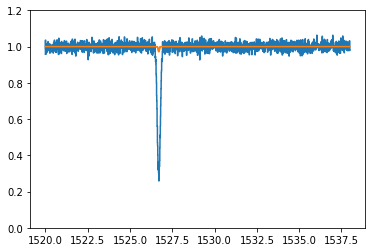

In [48]:
rho = 1e-4           # a semi-typical CGM density
loc_cm = 3.086e+21   # a kpc
vel_const = 0.
Temp= 3e4

logN_guess, b_guess, vel_p_guess= estimate_parameter_single_cell(
    np.log10(rho), np.log10(loc_cm), vel_const, np.log10(Temp))
    
print(logN_guess, b_guess, vel_p_guess)

theta=np.concatenate(([logN_guess],[b_guess],[vel_p_guess]))
outflux_guess= s.model_flux(theta,wave)

# Add error
fnorm_guess= outflux_guess #+ np.random.normal(0., .02, len(wave))
enorm_guess= 0.02 * np.ones((len(wave),))

plt.step(wave,fnorm)
plt.step(wave,fnorm_guess)
plt.ylim([0.,1.2])

# Setup Likelihoods
And define choices about how many chains and steps will be taken for the MCMC operations

In [94]:
perturbation=1e-1
no_of_Chain=150
no_of_steps=3000

text_label=['rho', 'len', 'solar', 'f_c', 'vel_const', 'temp', 'lnf']
#lb   = [-10, 10, -4, -1, -500., 1, -np.inf]
#ub   = [2  , 25,  1,  0,  500., 9,  0.0   ]

lb   = [-10, 10, -4, -1, -500., 1 ]
ub   = [2  , 25,  1,  0,  500., 6 ]

length_of_lb = len(lb)
ndim, nwalkers = length_of_lb, no_of_Chain

######## Computing Likelihoods######
def lnprior(theta, lb, ub):
    for index in range(0, len(lb)):
        if (lb[index] > theta[index]) or (ub[index] < theta[index]):
            return -np.inf
    return 0.0

def lnlike(theta, model, x, y, yerr):
    model_y = model(theta, x)
    inv_sigma2 = 1.0/(yerr**2 )
    all_c2_values = (y - model_y) ** 2 * inv_sigma2  - np.log(inv_sigma2)
    return -0.5 * (np.sum( all_c2_values  )) 

def lnprob(theta, lb, ub, model, x, y, yerr):
    lp = lnprior(theta, lb, ub)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, model, x, y, yerr)

def optimize_guess(model, theta, lb, ub, x, y, yerr):
    nll = lambda *args: -lnprob(*args)
    result = op.minimize(nll, [theta], args=(lb, ub, model, x, y, yerr))
    p = result["x"]
    return p



def old_complicated_lnlike(theta, model, x, y, yerr):
    model_y = model(theta, x)
    wave_min = x[  np.argmin(model_y) ]    # wavelength asssociated with line minimum
    wave_off = np.abs( x - wave_min )      # wavelength offset from peak line strength 
    mod_y = (-1.0*(model_y - 1.0) )
    mod_y = np.abs( mod_y / np.max(mod_y) - 0.5 )  
    wave_half_max = x[ np.argmin(mod_y) ]
    fwhm = np.max(  [1.0, 2.0*np.abs(wave_min - wave_half_max)]  )
    cull_index = (wave_off < fwhm*3.0)
    #yerr_mod = yerr * 10.0**(wave_off/(1.0*fwhm))
    yerr_mod = yerr
#    yerr_mod[cull_index] = np.max(yerr_mod)*10.0
#    inv_sigma2 = 1.0 / (yerr ** 2)
#    inv_sigma2 = 1.0/(yerr_mod**2 + model_y**2*np.exp(2*theta[-1])*0 )
    inv_sigma2 = 1.0/(yerr_mod**2 )

#    print(theta)
#    print("Min/Max of model_y is {:8.4f}/{:8.4f}".format(np.min(model_y),np.max(model_y)))
    all_c2_values = (y - model_y) ** 2 * inv_sigma2  #- np.log(inv_sigma2)
#    print("Min/Max of chi-squared values are {:8.4f}/{:8.4f}".format(np.min(all_c2_values),np.max(all_c2_values)))
#    print("lnlike returned value is {:16.8f}".format( -0.5 * (np.sum( all_c2_values  ))) )
    return -0.5 * (np.sum( all_c2_values[cull_index]  ))

Current Starting Position
13.029395921727131 18.876814294814142 0.0
Input values were (logN,b,v):
[  14.    13.5   15.    20.    21.    29.    50.   -10.  -120. ]
Optimizing Guess ***********
[-3.         21.48939592  0.          5.47712125]


(0.0, 1.2)

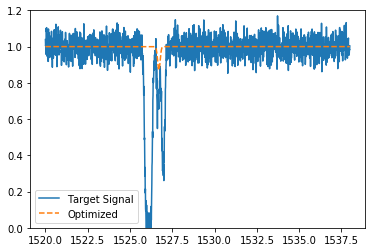

In [86]:
rho    = 1e-3           # a semi-typical CGM density
loc_cm = 3.086e+21      # a kpc
solar  =1.05
f_c    = 0.5
vel_const = 0.
temp   =3e5
initial_beta_guess = [np.log10(rho), np.log10(loc_cm), vel_const, np.log10(temp)]    #,  1e-5]


beta = initial_beta_guess
logN_, b_, vel_p_= estimate_parameter_single_cell(beta[0], beta[1], beta[2], beta[3])

print("Current Starting Position")
print(logN_, b_, vel_p_)
print("Input values were (logN,b,v):")
print(orig_values.flatten())

print('Optimizing Guess ***********')

popt = optimize_guess(model_guess, beta, lb, ub, wave, fnorm, enorm)
print(popt)

outflux_opt_guess= model_guess( popt, wave)

# Add error
fnorm_opt_guess= outflux_opt_guess #+ np.random.normal(0., .02, len(wave))
enorm_opt_guess= 0.02 * np.ones((len(wave),))

plt.plot(wave,fnorm, label='Target Signal')
plt.plot(wave,fnorm_opt_guess, ls='--', label='Optimized')
plt.legend()
plt.ylim([0.,1.2])

In [97]:
perturbation=1e-6
no_of_Chain=500
no_of_steps=3000

text_label=['rho', 'len', 'vel_const', 'temp']
lb        = [-10, 10, -500., 1 ]
ub        = [2  , 25,  500., 9  ]

length_of_lb = len(lb)
ndim, nwalkers = length_of_lb, no_of_Chain## Do the first MCMC operation.

In [88]:
guesses = [popt + perturbation * np.random.randn(ndim) for i in range(nwalkers)]
print("Starting emcee ***********")
burntime = np.round(no_of_steps * .2)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=1, args=(lb, ub, model_guess, wave, fnorm, enorm))
print("Start Burntime Calculations ***********")

pos, prob, state = sampler.run_mcmc(guesses, burntime)  #First Burning some steps
sampler.reset()

print("Done Burning Steps! Now starting the Final Calculations:")
print("*****************")
for i, result in enumerate(sampler.sample(pos, iterations=no_of_steps)):
    n = int((width+1) * float(i) / no_of_steps)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
sys.stdout.write("\n")

best_fit = print_and_plot_results(sampler, wave, fnorm)
plt.plot(wave,fnorm_opt_guess,label='opt guess', ls='--')
plt.legend()

Starting emcee ***********
Start Burntime Calculations ***********
Done Burning Steps! Now starting the Final Calculations:
*****************
[#                             ]emcee: Exception while calling your likelihood function:
  params: [  -2.79580317   23.18522431 -120.33578011    5.88151531]
  args: ([-10, 10, -500.0, 1], [2, 25, 500.0, 9], <function model_guess at 0x0000024C93AE33A8>, array([1520.  , 1520.01, 1520.02, ..., 1537.97, 1537.98, 1537.99]), array([1.03865584, 1.00376485, 1.01059659, ..., 0.98520534, 0.98143044,
       1.00362473]), array([0.02, 0.02, 0.02, ..., 0.02, 0.02, 0.02]))
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "C:\Users\drewg\Anaconda3\lib\site-packages\emcee\ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-85-ce8b54f0c7d4>", line 32, in lnprob
    return lp + lnlike(theta, model, x, y, yerr)
  File "<ipython-input-85-ce8b54f0c7d4>", line 23, in lnlike
    model_y = model(theta, x)
  File "<ipython-input-46-de6053b739f1>", line 52, in model_guess
    outflux= s.model_flux(theta,wave)
  File "C:\Users\drewg\Research\Paul's example Notebook\rbvfit\model.py", line 69, in model_flux
    ss3, flx = r.create_model_simple(theta, wave, line)
  File "C:\Users\drewg\Research\Paul's example Notebook\rbvfit\rb_vfit.py", line 95, in create_model_simple
    voigt_one[:,i]=voigt(line.lines[i].wave0,line.lines[i].gamma,line.lines[i].f,N[i],b[i],vel[i],Cf,specw/(1.+line.lines[i].z))
  File "C:\Users\drewg\Research\Paul's example Notebook\rbvfit\rb_vfit.py", line 62, in voigt
    return (1.-Cf)+Cf*np.exp(-voigt

KeyboardInterrupt: 

In [ ]:
samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain
st=np.median(samples,axis=0)#np.median(sampler.flatchain, axis=0)
print(st)
print(lnlike(st, model_guess, wave, fnorm, enorm))

In [ ]:
samples = sampler.chain[:, :, :].reshape((-1, ndim))
sampler_ = np.array( sampler.chain )

for this_dim in range(sampler_.shape[2]):   # number of parameters
    for walker_nr in range(sampler_.shape[0]):
        plt.step(range(sampler_.shape[1]), sampler_[walker_nr,:,this_dim])
    plt.show()

In [ ]:
make_corner_plots(sampler)

## Now try something just a bit more complicated.  Multiple line components.

In [ ]:
wave=np.arange(1520.,1538.,0.01)
# We are setting up 3 clumps at z = 0
# For SiII 1526 absorption
# With default 6.5 pixel FWHM of HST/COS and Gaussian convolution
n_clouds = 3
zabs=np.zeros((n_clouds))
lambda_rest = 1526.9 * np.ones((n_clouds))
s=m.create_voigt(zabs,lambda_rest)

#Properties of the lines (column density, dopler b, velocity)
logN=np.array([14.,13.5, 15.])
b=np.array(   [20.,21.,29.])
v=np.array(   [50.,-10.,-120.])
theta=np.concatenate((logN,b,v))

outflux= s.model_flux(theta,wave)
orig_values = np.array([logN, b, v])

# Add error
fnorm= outflux + np.random.normal(0., .05, len(wave))
enorm= 0.02 * np.ones((len(wave),))

plt.step(wave,fnorm)
plt.ylim([0.,1.2])


fig, ax = plt.subplots(figsize=(8, 5))
    
ax.plot(wave,fnorm, label='Observed Si II Line')
#ax.legend(fontsize=20)
ax.set_xlim([np.mean(lambda_rest)-3, np.mean(lambda_rest)+3])
ax.set_ylim([0.,1.2])
ax.set_ylabel(r'$\mathrm{Normalized\;Flux}$')
ax.set_xlabel(r'$\mathrm{Wavelength (\AA)}$')
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)
    #plt.gcf().

In [ ]:
beta = initial_beta_guess
logN_, b_, vel_p_= estimate_parameter_single_cell(beta[0], beta[1], beta[2], beta[3])
print("Current Starting Position (logN,b,vel_p): ({:8.4f},{:8.4f},{:8.4f})".format(logN_,b_,vel_p_))
print("Input values were (logN,b,v): ({:8.4f},{:8.4f},{:8.4f})".format(orig_values.flatten()[0],orig_values.flatten()[1],orig_values.flatten()[2]))

print('Optimizing Guess ***********')
popt = optimize_guess(model_guess, beta, lb, ub, wave, fnorm, enorm)

######
guesses = [popt + perturbation * np.random.randn(ndim) for i in range(nwalkers)]
print("Starting emcee ***********")
burntime = np.round(no_of_steps * .2)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=32, args=(lb, ub, model_guess, wave, fnorm, enorm))
print("Start Burntime Calculations ***********")

pos, prob, state = sampler.run_mcmc(guesses, burntime)     #First Burning some steps
sampler.reset()

print("Done Burning Steps!  Now starting the Final Calculations:")
for i, result in enumerate(sampler.sample(pos, iterations=no_of_steps)):
    n = int((width+1) * float(i) / no_of_steps)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
sys.stdout.write("\n")

cloud1_best_fit = print_and_plot_results(sampler, wave, fnorm)

In [ ]:
cloud1_best_fit = print_and_plot_results(sampler, wave, fnorm)
make_corner_plots(sampler)

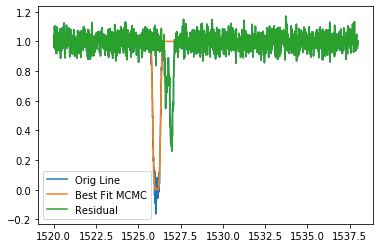

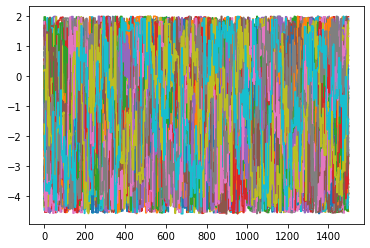

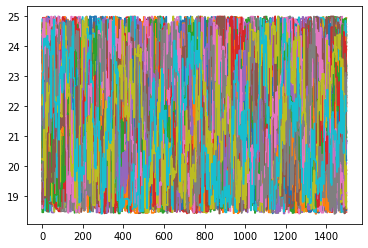

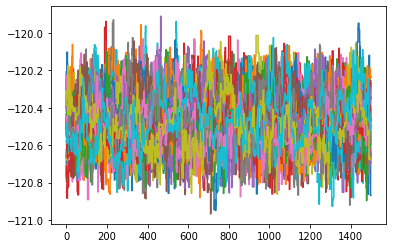

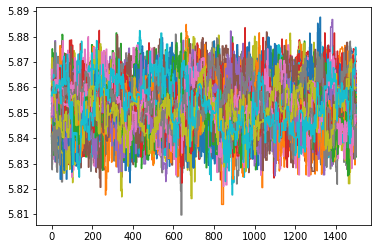

In [66]:
fnorm_2 = fnorm - cloud1_best_fit + 1.0
plt.step(wave,fnorm, label='Orig Line')
plt.step(wave,cloud1_best_fit, label='Best Fit MCMC')
plt.plot(wave,fnorm_2, label='Residual')
plt.legend()
plt.show()


samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
sampler_ = np.array( sampler.chain )
#print(sampler.shape)

for this_dim in range(sampler_.shape[2]):   # number of parameters
    for walker_nr in range(sampler_.shape[0]):
        plt.step(range(sampler_.shape[1]), sampler_[walker_nr,:,this_dim])
    plt.show()

In [67]:
beta = initial_beta_guess
logN_, b_, vel_p_= estimate_parameter_single_cell(beta[0], beta[1], beta[2], beta[3])

print('Optimizing Guess ***********')
popt = optimize_guess(model_guess, beta, lb, ub, wave, fnorm_2, enorm)

guesses = [popt + perturbation * np.random.randn(ndim) for i in range(nwalkers)]
print("Starting emcee ***********")
burntime = np.round(no_of_steps * .2)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=8, args=(lb, ub, model_guess, wave, fnorm_2, enorm))
print("Start Burntime Calculations ***********")

pos, prob, state = sampler.run_mcmc(guesses, burntime) #First Burning some steps
sampler.reset()

print("Done Burning Steps!  Now starting the Final Calculations:")
print("*****************")
#Now Running mcmc
for i, result in enumerate(sampler.sample(pos, iterations=no_of_steps)):
    n = int((width+1) * float(i) / no_of_steps)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
sys.stdout.write("\n")

Optimizing Guess ***********
Starting emcee ***********
Start Burntime Calculations ***********
Done Burning Steps!  Now starting the Final Calculations:
*****************
[##############################]


Derived values are (logN,b,v): ( 14.0137,  25.7913,  48.4307)


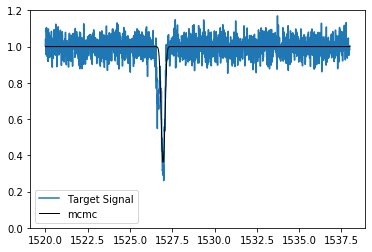

In [68]:
cloud2_best_fit = print_and_plot_results(sampler, wave,fnorm_2)

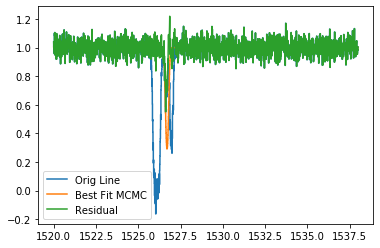

In [69]:
fnorm_3 = fnorm_2 - cloud2_best_fit + 1.0
plt.step(wave,fnorm, label='Orig Line')
plt.step(wave,best_fit, label='Best Fit MCMC')
plt.plot(wave,fnorm_3, label='Residual')
plt.legend()
plt.show()

In [70]:
beta = initial_beta_guess
logN_, b_, vel_p_= estimate_parameter_single_cell(beta[0], beta[1], beta[2], beta[3])

print('Optimizing Guess ***********')
popt = optimize_guess(model_guess, beta, lb, ub, wave, fnorm_3, enorm)

guesses = [popt + perturbation * np.random.randn(ndim) for i in range(nwalkers)]
print("Starting emcee ***********")
burntime = np.round(no_of_steps * .2)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=8, args=(lb, ub, model_guess, wave, fnorm_3, enorm))
print("Start Burntime Calculations ***********")

pos, prob, state = sampler.run_mcmc(guesses, burntime) #First Burning some steps
sampler.reset()

print("Done Burning Steps!  Now starting the Final Calculations:")
print("*****************")
#Now Running mcmc
for i, result in enumerate(sampler.sample(pos, iterations=no_of_steps)):
    n = int((width+1) * float(i) / no_of_steps)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
sys.stdout.write("\n")

Optimizing Guess ***********
Starting emcee ***********
Start Burntime Calculations ***********
Done Burning Steps!  Now starting the Final Calculations:
*****************
[##############################]


Derived values are (logN,b,v): ( 13.4010,  14.6395, -11.8657)


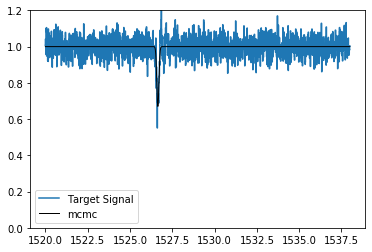

In [71]:
cloud3_best_fit = print_and_plot_results(sampler, wave,fnorm_3)

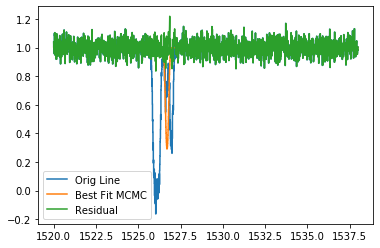

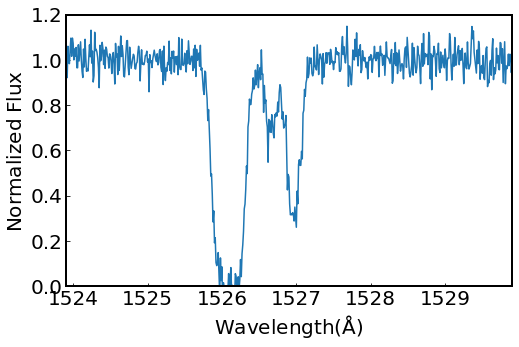

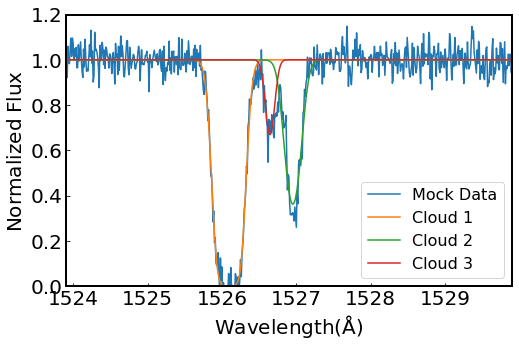

In [72]:
fnorm_4 = fnorm_3 - cloud3_best_fit + 1.0
plt.step(wave,fnorm, label='Orig Line')
plt.step(wave,best_fit, label='Best Fit MCMC')
plt.plot(wave,fnorm_4, label='Residual')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
    
ax.plot(wave,fnorm, label='Mock Data')
ax.set_xlim([np.mean(lambda_rest)-3, np.mean(lambda_rest)+3])
ax.set_ylim([0.,1.2])
ax.set_ylabel(r'$\mathrm{Normalized\;Flux}$')
ax.set_xlabel(r'$\mathrm{Wavelength (\AA)}$')
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)


fig, ax = plt.subplots(figsize=(8, 5))
    
ax.plot(wave,fnorm, label='Mock Data')
ax.plot(wave,cloud1_best_fit, label='Cloud 1')
ax.plot(wave,cloud2_best_fit, label='Cloud 2')
ax.plot(wave,cloud3_best_fit, label='Cloud 3')
ax.legend(fontsize=16)

ax.set_xlim([np.mean(lambda_rest)-3, np.mean(lambda_rest)+3])
ax.set_ylim([0.,1.2])
ax.set_ylabel(r'$\mathrm{Normalized\;Flux}$')
ax.set_xlabel(r'$\mathrm{Wavelength (\AA)}$')
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)

Optimizing Guess ***********
Starting emcee ***********
Start Burntime Calculations ***********
Done Burning Steps!  Now starting the Final Calculations:
*****************
[##############################]
Derived values are (logN,b,v): ( 11.6810,   1.5830,  52.9096)


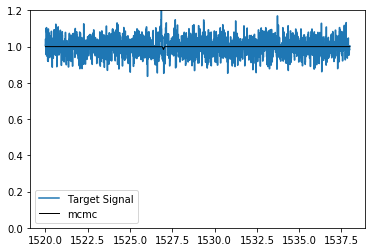

In [73]:
beta = initial_beta_guess
logN_, b_, vel_p_= estimate_parameter_single_cell(beta[0], beta[1], beta[2], beta[3])

print('Optimizing Guess ***********')
popt = optimize_guess(model_guess, beta, lb, ub, wave, fnorm_4, enorm)

guesses = [popt + perturbation * np.random.randn(ndim) for i in range(nwalkers)]
print("Starting emcee ***********")
burntime = np.round(no_of_steps * .2)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=8, args=(lb, ub, model_guess, wave, fnorm_4, enorm))
print("Start Burntime Calculations ***********")

pos, prob, state = sampler.run_mcmc(guesses, burntime) #First Burning some steps
sampler.reset()

print("Done Burning Steps!  Now starting the Final Calculations:")
print("*****************")
#Now Running mcmc
for i, result in enumerate(sampler.sample(pos, iterations=no_of_steps)):
    n = int((width+1) * float(i) / no_of_steps)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
sys.stdout.write("\n")

best_fit = print_and_plot_results(sampler, wave,fnorm_4)

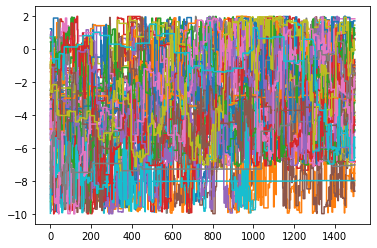

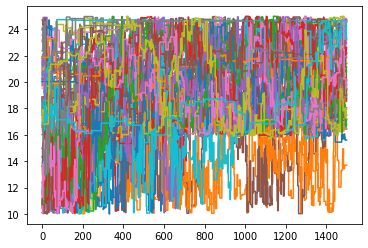

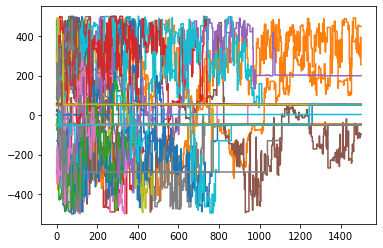

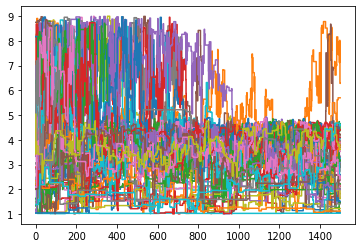

(75000, 4)


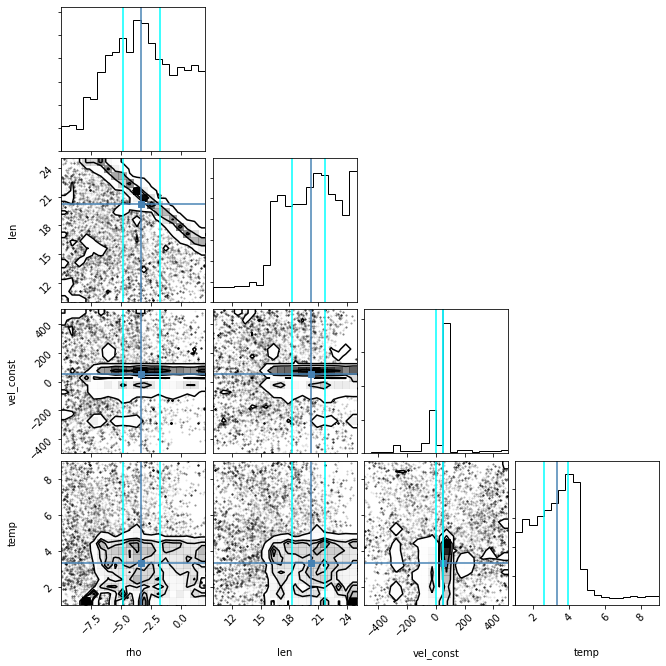

In [74]:
samples = sampler.chain[:, 0:, :].reshape((-1, ndim))
sampler_ = np.array( sampler.chain )
#print(sampler.shape)

for this_dim in range(sampler_.shape[2]):   # number of parameters
    for walker_nr in range(sampler_.shape[0]):
        plt.step(range(sampler_.shape[1]), sampler_[walker_nr,:,this_dim])
    plt.show()
    
print(samples.shape)

make_corner_plots(sampler)

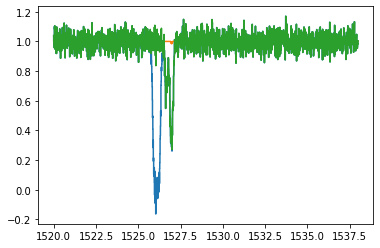

In [75]:
fnorm_3 = fnorm_2 - best_fit + 1.0
plt.step(wave,fnorm)
plt.step(wave,best_fit)
plt.plot(wave,fnorm_3)

# Drew's brute strength (one step) attempt

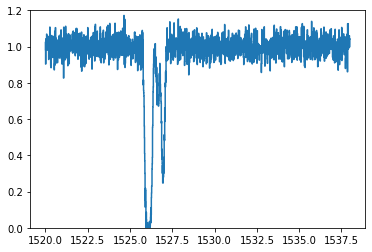

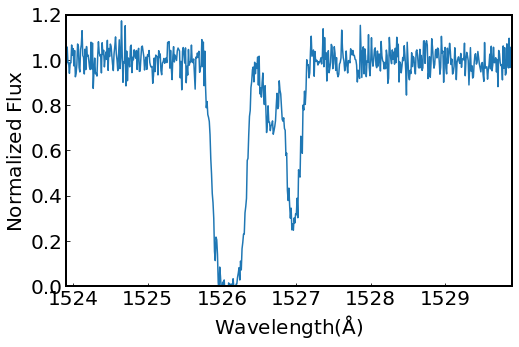

In [98]:
# We are setting up 3 clumps at z = 0
# For SiII 1526 absorption
# With default 6.5 pixel FWHM of HST/COS and Gaussian convolution
n_clouds = 3
zabs=np.zeros((n_clouds))
lambda_rest = 1526.9 * np.ones((n_clouds))
s=m.create_voigt(zabs,lambda_rest)

#Properties of the lines (column density, dopler b, velocity)
logN=np.array([14.,13.5, 15.])
b=np.array(   [20.,21.,29.])
v=np.array(   [50.,-10.,-120.])
theta=np.concatenate((logN,b,v))

outflux= s.model_flux(theta,wave)
orig_values = np.array([logN, b, v])

# Add error
fnorm_1= outflux + np.random.normal(0., .05, len(wave))
enorm= 0.02 * np.ones((len(wave),))

plt.step(wave,fnorm_1)
plt.ylim([0.,1.2])


fig, ax = plt.subplots(figsize=(8, 5))
    
ax.plot(wave,fnorm_1, label='Observed Si II Line')
#ax.legend(fontsize=20)
ax.set_xlim([np.mean(lambda_rest)-3, np.mean(lambda_rest)+3])
ax.set_ylim([0.,1.2])
ax.set_ylabel(r'$\mathrm{Normalized\;Flux}$')
ax.set_xlabel(r'$\mathrm{Wavelength (\AA)}$')
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)
    #plt.gcf().

Current Starting Position (logN,b,vel_p): ( 13.0294, 18.8768,  0.0000)
Input values were (logN,b,v): ( 14.0000, 13.5000, 15.0000)
Optimizing Guess ***********
Starting emcee ***********
Start Burntime Calculations ***********
Done Burning Steps!  Now starting the Final Calculations:
[##############################]
Done Burning Steps!  Now starting the Final Calculations:
[##############################]
Done Burning Steps!  Now starting the Final Calculations:
[##############################]
Done Burning Steps!  Now starting the Final Calculations:
[##############################]
Done Burning Steps!  Now starting the Final Calculations:
[##############################]
Derived values are (logN,b,v): ( 16.2249,  29.1401, -119.0037)
Derived values are (logN,b,v): ( 15.7549,   0.2971,  48.9798)
Derived values are (logN,b,v): ( 13.0505,  15.6323, -13.0027)
Derived values are (logN,b,v): ( 11.3228,   1.1811, -166.8513)


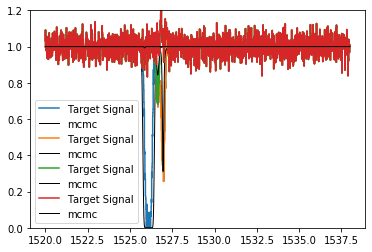

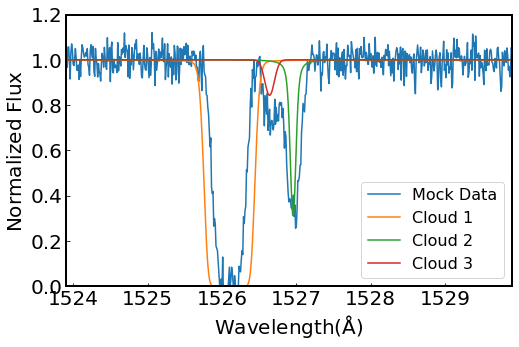

In [104]:
perturbation=1e-6
no_of_Chain=50
no_of_steps=1500

text_label=['rho', 'len', 'vel_const', 'temp']
lb        = [-10, 10, -500., 1 ]
ub        = [2  , 25,  500., 9  ]

length_of_lb = len(lb)
ndim, nwalkers = length_of_lb, no_of_Chain

beta = initial_beta_guess
logN_, b_, vel_p_= estimate_parameter_single_cell(beta[0], beta[1], beta[2], beta[3])
print("Current Starting Position (logN,b,vel_p): ({:8.4f},{:8.4f},{:8.4f})".format(logN_,b_,vel_p_))
print("Input values were (logN,b,v): ({:8.4f},{:8.4f},{:8.4f})".format(orig_values.flatten()[0],orig_values.flatten()[1],orig_values.flatten()[2]))

print('Optimizing Guess ***********')
popt = optimize_guess(model_guess, beta, lb, ub, wave, fnorm_1, enorm)

guesses = [popt + perturbation * np.random.randn(ndim) for i in range(nwalkers)]
print("Starting emcee ***********")
burntime = np.round(no_of_steps * .2)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=32, args=(lb, ub, model_guess, wave, fnorm_1, enorm))
print("Start Burntime Calculations ***********")

pos, prob, state = sampler.run_mcmc(guesses, burntime)     #First Burning some steps
sampler.reset()

print("Done Burning Steps!  Now starting the Final Calculations:")
for i, result in enumerate(sampler.sample(pos, iterations=no_of_steps)):
    n = int((width+1) * float(i) / no_of_steps)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
sys.stdout.write("\n")

popt1 = optimize_guess(model_guess, beta, lb, ub, wave, fnorm_1, enorm)
popt2 = optimize_guess(model_guess, beta, lb, ub, wave, fnorm_2, enorm)
popt3 = optimize_guess(model_guess, beta, lb, ub, wave, fnorm_3, enorm)
popt4 = optimize_guess(model_guess, beta, lb, ub, wave, fnorm_4, enorm)

guesses1 = [popt1 + perturbation * np.random.randn(ndim) for i in range(nwalkers)]
guesses2 = [popt2 + perturbation * np.random.randn(ndim) for i in range(nwalkers)]
guesses3 = [popt3 + perturbation * np.random.randn(ndim) for i in range(nwalkers)] 
guesses4 = [popt4 + perturbation * np.random.randn(ndim) for i in range(nwalkers)]

fnorm_1= outflux + np.random.normal(0., .05, len(wave))
fnorm_2 = fnorm_1 - cloud_best_fit_1 + 1.0
fnorm_3 = fnorm_2 - cloud_best_fit_2 + 1.0
fnorm_4 = fnorm_3 - cloud_best_fit_3 + 1.0


#sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=32, args=(lb, ub, model_guess, wave, fnorm, enorm))
sampler1 = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=32, args=(lb, ub, model_guess, wave, fnorm_1, enorm))
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=32, args=(lb, ub, model_guess, wave, fnorm_2, enorm))
sampler3 = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=32, args=(lb, ub, model_guess, wave, fnorm_3, enorm))
sampler4 = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=32, args=(lb, ub, model_guess, wave, fnorm_4, enorm))

pos, prob, state = sampler1.run_mcmc(guesses, burntime)     #First Burning some steps
sampler1.reset()
pos, prob, state = sampler2.run_mcmc(guesses, burntime)     #First Burning some steps
sampler2.reset()
pos, prob, state = sampler3.run_mcmc(guesses, burntime)     #First Burning some steps
sampler3.reset()
pos, prob, state = sampler4.run_mcmc(guesses, burntime)     #First Burning some steps
sampler4.reset()

print("Done Burning Steps!  Now starting the Final Calculations:")
for i, result in enumerate(sampler1.sample(pos, iterations=no_of_steps)):
    n = int((width+1) * float(i) / no_of_steps)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
sys.stdout.write("\n")
print("Done Burning Steps!  Now starting the Final Calculations:")
for i, result in enumerate(sampler2.sample(pos, iterations=no_of_steps)):
    n = int((width+1) * float(i) / no_of_steps)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
sys.stdout.write("\n")
print("Done Burning Steps!  Now starting the Final Calculations:")
for i, result in enumerate(sampler3.sample(pos, iterations=no_of_steps)):
    n = int((width+1) * float(i) / no_of_steps)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
sys.stdout.write("\n")
print("Done Burning Steps!  Now starting the Final Calculations:")
for i, result in enumerate(sampler4.sample(pos, iterations=no_of_steps)):
    n = int((width+1) * float(i) / no_of_steps)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
sys.stdout.write("\n")

cloud_best_fit_1 = print_and_plot_results(sampler1, wave,fnorm_1)
cloud_best_fit_2 = print_and_plot_results(sampler2, wave,fnorm_2)
cloud_best_fit_3 = print_and_plot_results(sampler3, wave,fnorm_3)
cloud_best_fit_4 = print_and_plot_results(sampler4, wave,fnorm_4)

fig, ax = plt.subplots(figsize=(8, 5))
    
ax.plot(wave,fnorm_1, label='Mock Data')
ax.plot(wave,cloud_best_fit_1, label='Cloud 1')
ax.plot(wave,cloud_best_fit_2, label='Cloud 2')
ax.plot(wave,cloud_best_fit_3, label='Cloud 3')
ax.legend(fontsize=16)

ax.set_xlim([np.mean(lambda_rest)-3, np.mean(lambda_rest)+3])
ax.set_ylim([0.,1.2])
ax.set_ylabel(r'$\mathrm{Normalized\;Flux}$')
ax.set_xlabel(r'$\mathrm{Wavelength (\AA)}$')
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)

## Now, lets try again, but in a more streamlined approach

(0.0, 1.2)

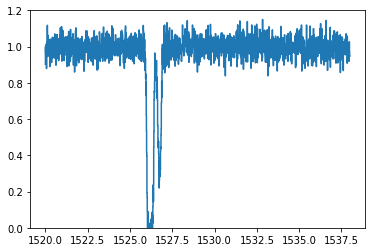

In [79]:
wave=np.arange(1520.,1538.,0.01)
# We are setting up 3 clumps at z = 0
# For SiII 1526 absorption
# With default 6.5 pixel FWHM of HST/COS and Gaussian convolution
n_clouds = 3
zabs=np.zeros((n_clouds))
lambda_rest = 1526.9 * np.ones((n_clouds))
s=m.create_voigt(zabs,lambda_rest)

#Properties of the lines (column density, dopler b, velocity)
logN=np.array([14.,13., 16.])
b=np.array([19.,15.,18.])
v=np.array([10.,-30.,-100.])
theta=np.concatenate((logN,b,v))

outflux= s.model_flux(theta,wave)
orig_values = np.array([logN, b, v])

# Add error
fnorm= outflux + np.random.normal(0., .05, len(wave))
enorm= 0.02 * np.ones((len(wave),))

plt.step(wave,fnorm)
perturbation=1e-1
no_of_Chain=100
no_of_steps=5000
plt.ylim([0.,1.2])

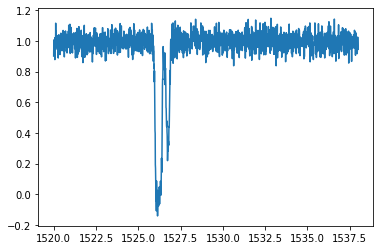

Optimizing Guess ***********


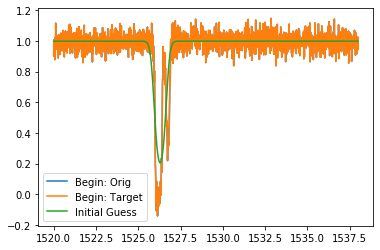

Starting emcee ***********
Start Burntime Calculations ***********
Done Burning Steps!  Now starting the Final Calculations:
[##############################]
Derived values are (logN,b,v): ( 14.6037,  67.0790, -81.5054)


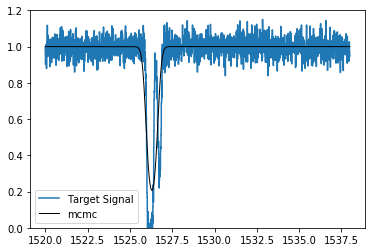

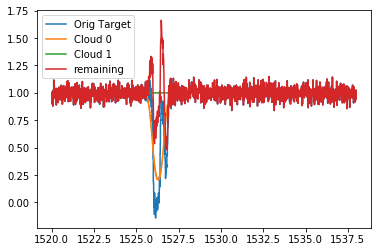

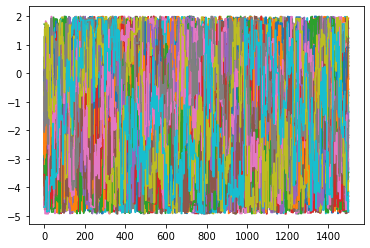

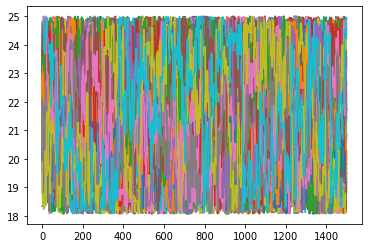

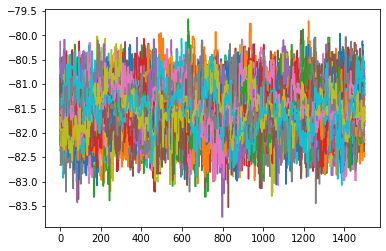

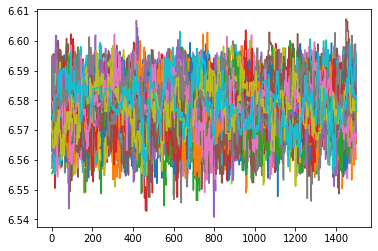

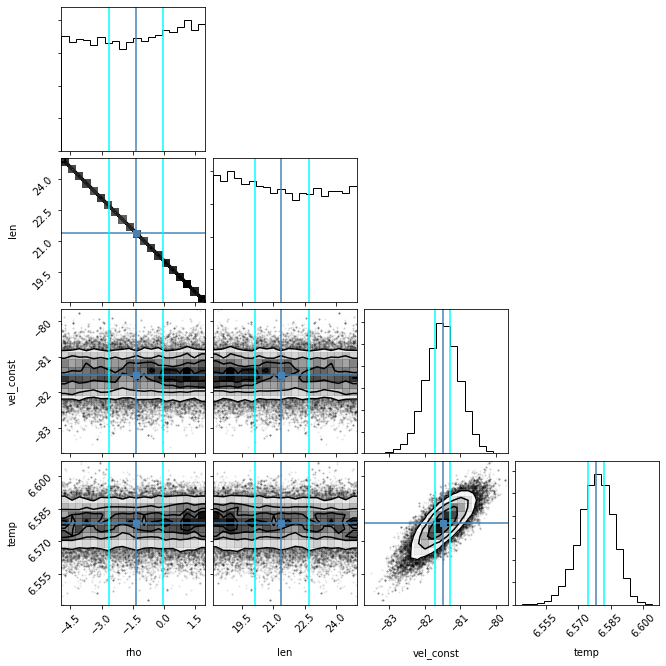

Optimizing Guess ***********


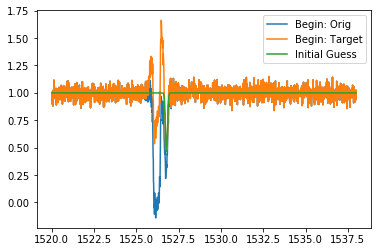

Starting emcee ***********
Start Burntime Calculations ***********
Done Burning Steps!  Now starting the Final Calculations:
[##############################]
Derived values are (logN,b,v): ( 13.6673,  13.8513,  14.1542)


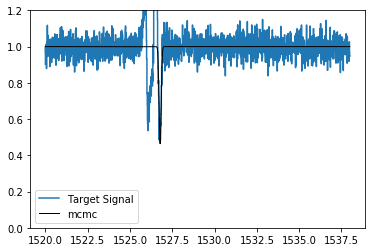

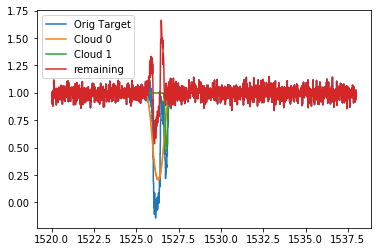

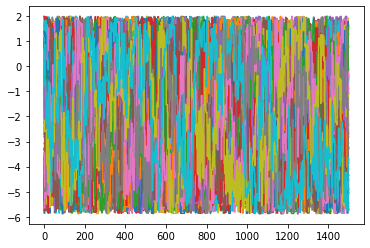

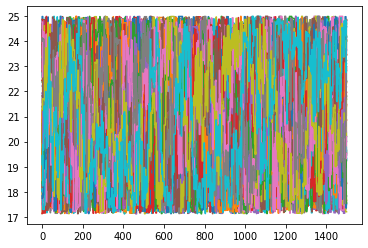

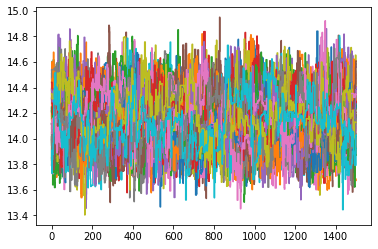

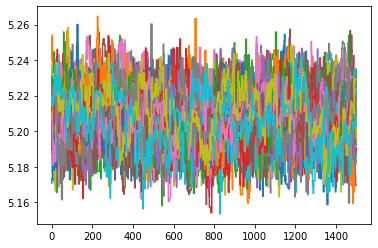

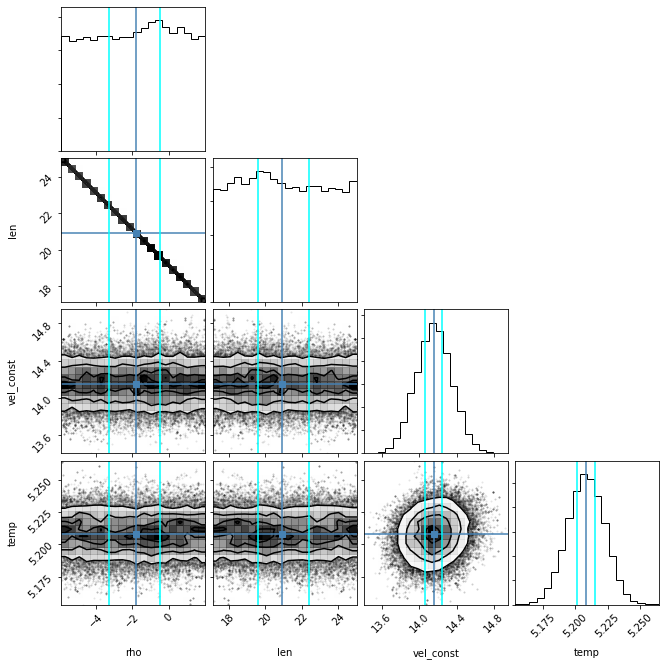

In [80]:
perturbation=1e-1
no_of_Chain=50
no_of_steps=1500
ndim, nwalkers = length_of_lb, no_of_Chain

n_clouds_in_fit = 2

plt.plot(wave,fnorm)
plt.show()

cloud_fluxes = np.ones(  (n_clouds_in_fit,fnorm.shape[0])  )

n_iterations = 1

orig_target = np.copy( fnorm )

for iteration in range(n_iterations):
    for cloud_number in range(n_clouds_in_fit):
        current_fitting_needs = np.copy( orig_target )
        for cl_nr in range(n_clouds_in_fit):
            if(cloud_number != cl_nr):
                current_fitting_needs -= (cloud_fluxes[cl_nr,:] - 1.0)
        plt.plot(wave,orig_target, label='Begin: Orig')
        plt.plot(wave,current_fitting_needs, label='Begin: Target')

        
        beta = initial_beta_guess
        logN_, b_, vel_p_= estimate_parameter_single_cell(beta[0], beta[1], beta[2], beta[3])

        print('Optimizing Guess ***********')
        popt = optimize_guess(model_guess, beta, lb, ub, wave, current_fitting_needs, enorm)

        plt.plot( wave, model_guess(np.array(popt), wave), label='Initial Guess' )
        plt.legend()
        plt.show()
        
        ######
        guesses = np.array( [popt + perturbation * np.random.randn(ndim) for i in range(nwalkers)] )
        #print(guesses.shape)
        #guesses[:,4] = np.linspace( -500,500,nwalkers   )
        #guesses[:,4] = np.linspace( -201,-199,nwalkers   )
        #print(guesses[:,4])
        
        print("Starting emcee ***********")
        burntime = np.round(no_of_steps * .2)
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=1, args=(lb, ub, model_guess, wave, current_fitting_needs, enorm))
        print("Start Burntime Calculations ***********")

        pos, prob, state = sampler.run_mcmc(guesses, burntime)     #First Burning some steps
        sampler.reset()

        print("Done Burning Steps!  Now starting the Final Calculations:")
        for i, result in enumerate(sampler.sample(pos, iterations=no_of_steps)):
            n = int((width+1) * float(i) / no_of_steps)
            sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
        sys.stdout.write("\n")

        cloud_fluxes[cloud_number,:] = print_and_plot_results(sampler, wave, current_fitting_needs)
        plt.show()

        plt.step(wave,orig_target,label='Orig Target')

        current_fitting_needs = np.copy( orig_target )
        for cl_nr in range(n_clouds_in_fit):
            current_fitting_needs -= (cloud_fluxes[cl_nr,:] - 1.0)
            plt.step(wave,cloud_fluxes[cl_nr,:], label="Cloud {:d}".format(cl_nr))

        plt.plot(wave,current_fitting_needs,label='remaining')
        plt.legend()
        plt.show()
        
        samples = sampler.chain[:, 0:, :].reshape((-1, ndim))
        sampler_ = np.array( sampler.chain )
        #print(sampler.shape)

        for this_dim in range(sampler_.shape[2]):   # number of parameters
            for walker_nr in range(sampler_.shape[0]):
                plt.step(range(sampler_.shape[1]), sampler_[walker_nr,:,this_dim])
            plt.show()
        
        make_corner_plots(sampler)
        plt.show()





In [81]:
def multi_component_model_guess(beta,wave,n_components=2):
    outflux = np.ones_like(wave)
    
    for this_component in range(n_components):
        log_rho    = np.array([beta[0 + this_component*4]])
        log_los_cm = np.array([beta[1 + this_component*4]])
        vel_p      = np.array([beta[2 + this_component*4]])
        log_temp   = np.array([beta[3 + this_component*4]])
                
        logN, b, vel_p= estimate_parameter_single_cell(log_rho, log_los_cm, vel_p, log_temp)
        
        theta  = np.concatenate((logN,b,vel_p))
        this_outflux= s.model_flux(theta,wave)
        outflux = outflux + (this_outflux - 1.0)
    
    return outflux

def print_and_plot_results_mc(sampler, wave, flux):
    samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))
    samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))


    st=np.median(samples,axis=0)
    for param_index in range(8):
        hist,edges = np.histogram(samples[:,param_index], bins=100)
        edges = (edges[:-1] + edges[1:])/2.0
        st[param_index] = edges[np.argmax(hist)] 
        
    #st=np.median(samples,axis=0)
    theta_prime=st[:]
    
    best_fit = multi_component_model_guess(theta_prime,wave)
    
    theta_prime_ = np.copy(theta_prime)
    theta_prime_[:4] = 0
    best_fit2 = multi_component_model_guess(theta_prime_,wave)

    theta_prime_ = np.copy(theta_prime)
    theta_prime_[4:] = 0
    best_fit3 = multi_component_model_guess(theta_prime_,wave)
    
    fig, ax = plt.subplots(figsize=(15, 10))
    
    ax.plot(wave,flux, label='SiII Observed Line')
    ax.plot(wave,best_fit2,color='r',linewidth=2,label='Could 1' )
    ax.plot(wave,best_fit3,color='g',linewidth=2,label='Cloud 2')
    ax.plot(wave,best_fit,color='k',linewidth=1,label='Total', ls='--')


    ax.legend(fontsize=20)
    ax.set_xlim([np.mean(lambda_rest)-3, np.mean(lambda_rest)+3])
    ax.set_ylim([0.,1.2])
    ax.set_ylabel(r'$\mathrm{Normalized\;Flux}$')
    ax.set_xlabel(r'$\mathrm{Wavelength (\AA)}$')
    ax.xaxis.set_tick_params(direction='in')
    ax.yaxis.set_tick_params(direction='in')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    #ax.axhline(linewidth=4)
    #ax.axvline(linewidth=4)

    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)
    #plt.gcf().
    
    return best_fit
    
def make_corner_plots_mc(sampler):
    samples=sampler.chain[:, 100:, :].reshape((-1, ndim))
    st=np.median(samples,axis=0)
    for param_index in range(8):
        hist,edges = np.histogram(samples[:,param_index], bins=100)
        edges = (edges[:-1] + edges[1:])/2.0
        st[param_index] = edges[np.argmax(hist)] 
        
    figure=corner.corner(samples, labels=text_label, truths=st)
    theta_prime=st

    value1 = np.percentile(samples,32,axis=0)
    value2 = np.percentile(samples,68,axis=0)    
    axes   = np.array(figure.axes).reshape((ndim, ndim))

    # Loop over the diagonal
    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline(value1[i], color="aqua")
        ax.axvline(value2[i], color="aqua")

    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(value1[xi],color="aqua")
            ax.axvline(value2[xi],color="aqua")

In [82]:
perturbation=1e-1
no_of_Chain=100
no_of_steps=150

n_components = 2

rho    = 1e-3           # a semi-typical CGM density
loc_cm = 3.086e+21      # a kpc
solar  =1.05
f_c    = 0.5
vel_const = 0.
temp   =3e5
initial_beta_guess = [np.log10(rho), np.log10(loc_cm), vel_const, np.log10(temp) ]


beta       = np.concatenate((initial_beta_guess,initial_beta_guess))
text_label = ['rho', 'len', 'vel_const', 'temp', 
              'rho', 'len', 'vel_const', 'temp' ]
lb_multi   = np.concatenate((lb,lb))
ub_multi   = np.concatenate((ub,ub))

#lb_multi[2] = -110.0
#ub_multi[2] = -90.0

#samples=sampler.chain[:, 250:, :].reshape((-1, ndim))
#st=np.median(samples,axis=0)
#initial_beta_guess = st

print(initial_beta_guess)


print("Summary of priors:")

for ijk in range(len(lb_multi)):
    if (ijk%4==0):
        print("  Cloud {:d} Summary:".format( np.rint(ijk/7).astype(np.int) ) )
    print("    {:10s} min/max = {:16.8f}  /  {:16.8f}".format(text_label[ijk], lb_multi[ijk],ub_multi[ijk])  )

length_of_lb = len(lb_multi)
ndim, nwalkers = length_of_lb, no_of_Chain

print('Optimizing Guess ***********')
popt = optimize_guess(multi_component_model_guess, beta, lb_multi, ub_multi, wave, fnorm, enorm)
#todo:  need to feed through n_components here?!?

guesses = np.array([popt + perturbation * np.random.randn(ndim) for i in range(nwalkers)])
print(guesses.shape)

#guesses[:,4] = -210 + perturbation * np.random.randn(nwalkers)
#guesses[:,11] = 40 + perturbation * np.random.randn(nwalkers)

print("Starting emcee ***********")
burntime = np.round(no_of_steps * .2)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=32,
                                args=(lb_multi, ub_multi, multi_component_model_guess, wave, fnorm, enorm))
print("Start Burntime Calculations ***********")

pos, prob, state = sampler.run_mcmc(guesses, burntime) #First Burning some steps
sampler.reset()

print("Done Burning Steps!  Now starting the Final Calculations:")
print("*****************")
#Now Running mcmc
for i, result in enumerate(sampler.sample(pos, iterations=no_of_steps)):
    n = int((width+1) * float(i) / no_of_steps)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
sys.stdout.write("\n")

[-3.0, 21.48939592172713, 0.0, 5.477121254719663]
Summary of priors:
  Cloud 0 Summary:
    rho        min/max =     -10.00000000  /        2.00000000
    len        min/max =      10.00000000  /       25.00000000
    vel_const  min/max =    -500.00000000  /      500.00000000
    temp       min/max =       1.00000000  /        9.00000000
  Cloud 1 Summary:
    rho        min/max =     -10.00000000  /        2.00000000
    len        min/max =      10.00000000  /       25.00000000
    vel_const  min/max =    -500.00000000  /      500.00000000
    temp       min/max =       1.00000000  /        9.00000000
Optimizing Guess ***********
(100, 8)
Starting emcee ***********
Start Burntime Calculations ***********
Done Burning Steps!  Now starting the Final Calculations:
*****************
[##############################]


Best value for rho is      -0.34344912
Best value for len is      20.29403785
Best value for vel_const is     -28.65684460
Best value for temp is       6.88565630
Best value for rho is      -7.81869933
Best value for len is      23.55180279
Best value for vel_const is      -9.69058615



Best value for temp is       3.63183586


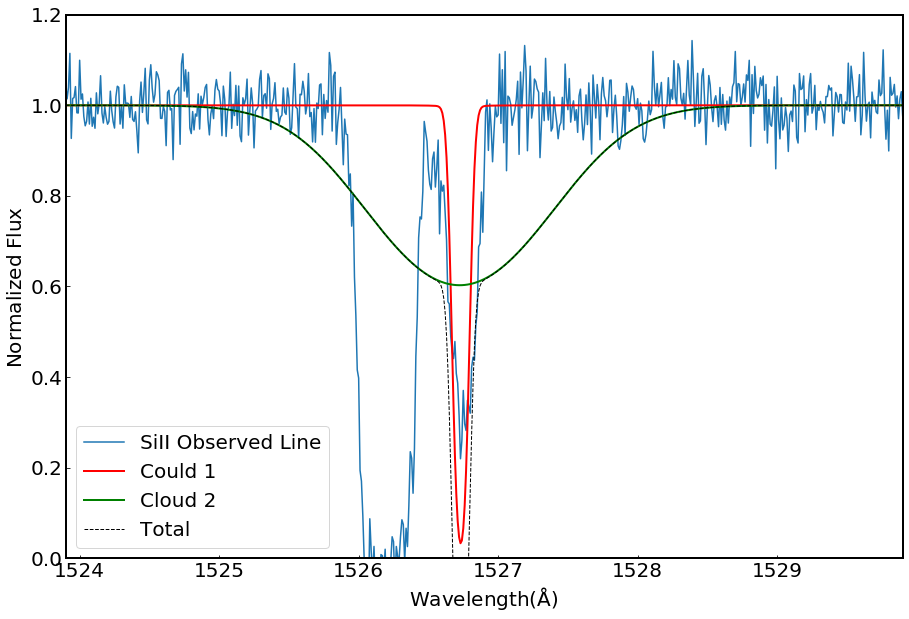

In [83]:
best_values = print_and_plot_results_mc(sampler, wave, fnorm)

samples=sampler.chain[:, 100:, :].reshape((-1, ndim))
st=np.median(samples,axis=0)


for ijk in range(len(st)):
    print("Best value for {:s} is {:16.8f}".format( text_label[ijk],st[ijk]) )
    if(ijk==6):
        print("\n\n")
    
#print(text_label) 

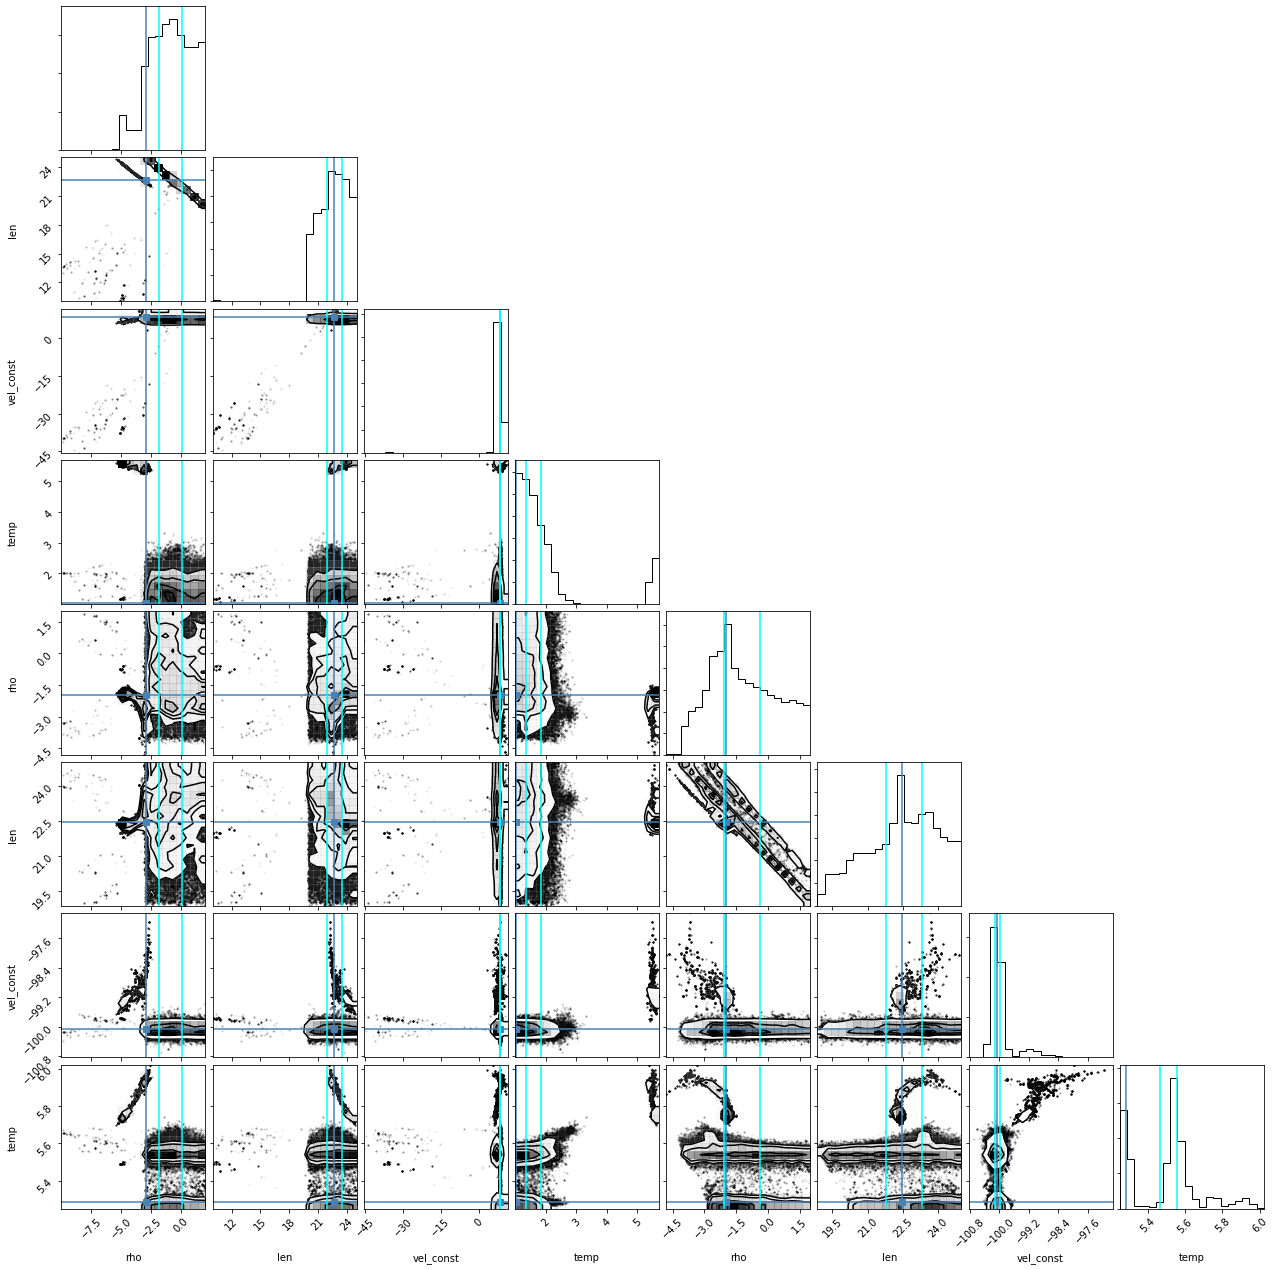

In [33]:
make_corner_plots_mc(sampler)

In [34]:
samples=sampler.chain[:, 250:, :].reshape((-1, ndim))
st=np.median(samples,axis=0)
stdev=np.std(samples,axis=0)
initial_beta_guess = st
print(initial_beta_guess)
print(stdev)

[  -0.92820246   22.73876108    8.49835505    1.5244919    -1.27124141
   22.45703906 -100.0587507     5.52478685]
[1.76887274 1.55457057 2.52279131 1.28946993 1.5463432  1.53032999
 0.33681804 0.17021591]


In [35]:
#perturbation=1e-1
no_of_Chain=100
no_of_steps=500

#n_components = 2

#rho    = 1e-3           # a semi-typical CGM density
#loc_cm = 3.086e+21      # a kpc
#solar  =1.05
#f_c    = 0.5
#vel_const = 0.
#temp   =3e5
#initial_beta_guess = [np.log10(rho), np.log10(loc_cm), vel_const, np.log10(temp) ]


#beta       = np.concatenate((initial_beta_guess,initial_beta_guess))
#text_label = ['rho', 'len', 'vel_const', 'temp', 
#              'rho', 'len', 'vel_const', 'temp' ]
#lb_multi   = np.concatenate((lb,lb))
#ub_multi   = np.concatenate((ub,ub))

lb_multi[2] = -110.0
ub_multi[2] = -90.0

#samples=sampler.chain[:, 250:, :].reshape((-1, ndim))
#st=np.median(samples,axis=0)
#initial_beta_guess = st

print(initial_beta_guess)


print("Summary of priors:")

for ijk in range(len(lb_multi)):
    if (ijk%4==0):
        print("  Cloud {:d} Summary:".format( np.rint(ijk/7).astype(np.int) ) )
    print("    {:10s} min/max = {:16.8f}  /  {:16.8f}".format(text_label[ijk], lb_multi[ijk],ub_multi[ijk])  )

length_of_lb = len(lb_multi)
ndim, nwalkers = length_of_lb, no_of_Chain

#print('Optimizing Guess ***********')
#popt = optimize_guess(multi_component_model_guess, beta, lb_multi, ub_multi, wave, fnorm, enorm)
#todo:  need to feed through n_components here?!?

guesses = np.array([initial_beta_guess + perturbation * np.random.randn(ndim) for i in range(nwalkers)])
print(guesses.shape)

#guesses[:,4] = -210 + perturbation * np.random.randn(nwalkers)
#guesses[:,11] = 40 + perturbation * np.random.randn(nwalkers)

print("Starting emcee ***********")
burntime = np.round(no_of_steps * .2)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=32,
                                args=(lb_multi, ub_multi, multi_component_model_guess, wave, fnorm, enorm))
print("Start Burntime Calculations ***********")

pos, prob, state = sampler.run_mcmc(guesses, burntime) #First Burning some steps
sampler.reset()

print("Done Burning Steps!  Now starting the Final Calculations:")
print("*****************")
#Now Running mcmc
for i, result in enumerate(sampler.sample(pos, iterations=no_of_steps)):
    n = int((width+1) * float(i) / no_of_steps)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
sys.stdout.write("\n")

[  -0.92820246   22.73876108    8.49835505    1.5244919    -1.27124141
   22.45703906 -100.0587507     5.52478685]
Summary of priors:
  Cloud 0 Summary:
    rho        min/max =     -10.00000000  /        2.00000000
    len        min/max =      10.00000000  /       25.00000000
    vel_const  min/max =    -110.00000000  /      -90.00000000
    temp       min/max =       1.00000000  /        9.00000000
  Cloud 1 Summary:
    rho        min/max =     -10.00000000  /        2.00000000
    len        min/max =      10.00000000  /       25.00000000
    vel_const  min/max =    -500.00000000  /      500.00000000
    temp       min/max =       1.00000000  /        9.00000000
(100, 8)
Starting emcee ***********
Start Burntime Calculations ***********
Done Burning Steps!  Now starting the Final Calculations:
*****************
[##############################]


Best value for rho is      -0.93689149
Best value for len is      22.71260977
Best value for vel_const is       8.48546035
Best value for temp is       1.51946293
Best value for rho is      -1.28285543
Best value for len is      22.45568780
Best value for vel_const is    -100.06017450



Best value for temp is       5.53009455


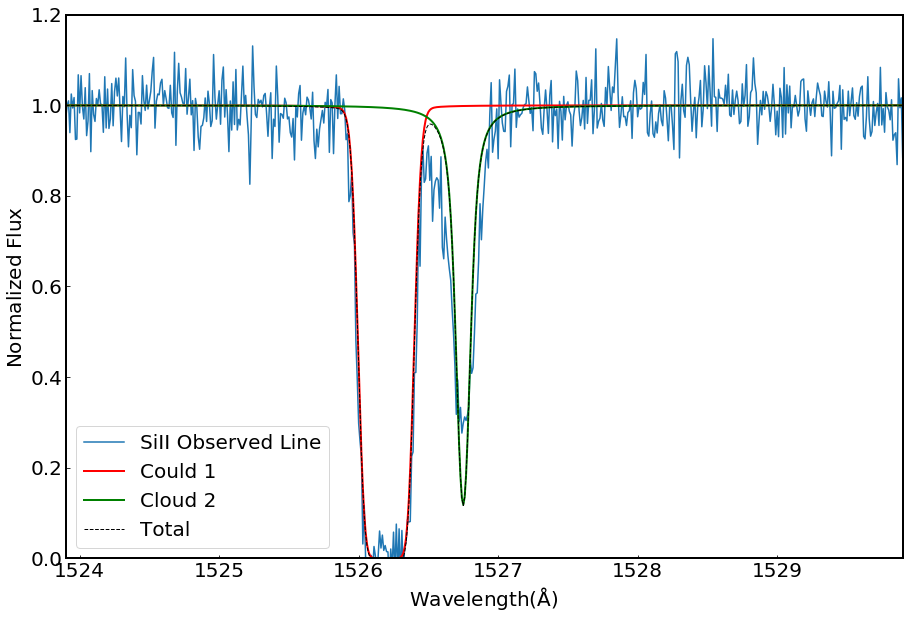

In [36]:
best_values = print_and_plot_results_mc(sampler, wave, fnorm)

samples=sampler.chain[:, 100:, :].reshape((-1, ndim))
st=np.median(samples,axis=0)


for ijk in range(len(st)):
    print("Best value for {:s} is {:16.8f}".format( text_label[ijk],st[ijk]) )
    if(ijk==6):
        print("\n\n")
    

In [37]:
samples=sampler.chain[:, 250:, :].reshape((-1, ndim))
st=np.median(samples,axis=0)
stdev=np.std(samples,axis=0)
initial_beta_guess = st
print(initial_beta_guess)
print(stdev)

[  -0.93689149   22.71260977    8.48546035    1.51946293   -1.28285543
   22.4556878  -100.0601745     5.53009455]
[0.0821889  0.08841737 0.08894669 0.09567187 0.09135103 0.10524242
 0.10205601 0.0973377 ]


In [38]:
#perturbation=1e-1
no_of_Chain=100
no_of_steps=500

#n_components = 2

#rho    = 1e-3           # a semi-typical CGM density
#loc_cm = 3.086e+21      # a kpc
#solar  =1.05
#f_c    = 0.5
#vel_const = 0.
#temp   =3e5
#initial_beta_guess = [np.log10(rho), np.log10(loc_cm), vel_const, np.log10(temp) ]


#beta       = np.concatenate((initial_beta_guess,initial_beta_guess))
#text_label = ['rho', 'len', 'vel_const', 'temp', 
#              'rho', 'len', 'vel_const', 'temp' ]
#lb_multi   = np.concatenate((lb,lb))
#ub_multi   = np.concatenate((ub,ub))

lb_multi[6] = initial_beta_guess[6] - 2.0*stdev[6]
ub_multi[6] = initial_beta_guess[6] + 2.0*stdev[6]

#samples=sampler.chain[:, 250:, :].reshape((-1, ndim))
#st=np.median(samples,axis=0)
#initial_beta_guess = st

print(initial_beta_guess)


print("Summary of priors:")

for ijk in range(len(lb_multi)):
    if (ijk%4==0):
        print("  Cloud {:d} Summary:".format( np.rint(ijk/7).astype(np.int) ) )
    print("    {:10s} min/max = {:16.8f}  /  {:16.8f}".format(text_label[ijk], lb_multi[ijk],ub_multi[ijk])  )

length_of_lb = len(lb_multi)
ndim, nwalkers = length_of_lb, no_of_Chain

#print('Optimizing Guess ***********')
#popt = optimize_guess(multi_component_model_guess, beta, lb_multi, ub_multi, wave, fnorm, enorm)
#todo:  need to feed through n_components here?!?

guesses = np.array([initial_beta_guess + perturbation * np.random.randn(ndim) for i in range(nwalkers)])
print(guesses.shape)

#guesses[:,4] = -210 + perturbation * np.random.randn(nwalkers)
#guesses[:,11] = 40 + perturbation * np.random.randn(nwalkers)

print("Starting emcee ***********")
burntime = np.round(no_of_steps * .2)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=32,
                                args=(lb_multi, ub_multi, multi_component_model_guess, wave, fnorm, enorm))
print("Start Burntime Calculations ***********")

pos, prob, state = sampler.run_mcmc(guesses, burntime) #First Burning some steps
sampler.reset()

print("Done Burning Steps!  Now starting the Final Calculations:")
print("*****************")
#Now Running mcmc
for i, result in enumerate(sampler.sample(pos, iterations=no_of_steps)):
    n = int((width+1) * float(i) / no_of_steps)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
sys.stdout.write("\n")

[  -0.93689149   22.71260977    8.48546035    1.51946293   -1.28285543
   22.4556878  -100.0601745     5.53009455]
Summary of priors:
  Cloud 0 Summary:
    rho        min/max =     -10.00000000  /        2.00000000
    len        min/max =      10.00000000  /       25.00000000
    vel_const  min/max =    -110.00000000  /      -90.00000000
    temp       min/max =       1.00000000  /        9.00000000
  Cloud 1 Summary:
    rho        min/max =     -10.00000000  /        2.00000000
    len        min/max =      10.00000000  /       25.00000000
    vel_const  min/max =    -100.26428652  /      -99.85606247
    temp       min/max =       1.00000000  /        9.00000000
(100, 8)
Starting emcee ***********
Start Burntime Calculations ***********
Done Burning Steps!  Now starting the Final Calculations:
*****************
[##############################]


Best value for rho is      -0.92248475
Best value for len is      22.71030091
Best value for vel_const is       8.47895067
Best value for temp is       1.51956637
Best value for rho is      -1.29470691
Best value for len is      22.46815195
Best value for vel_const is    -100.05980739



Best value for temp is       5.52799326


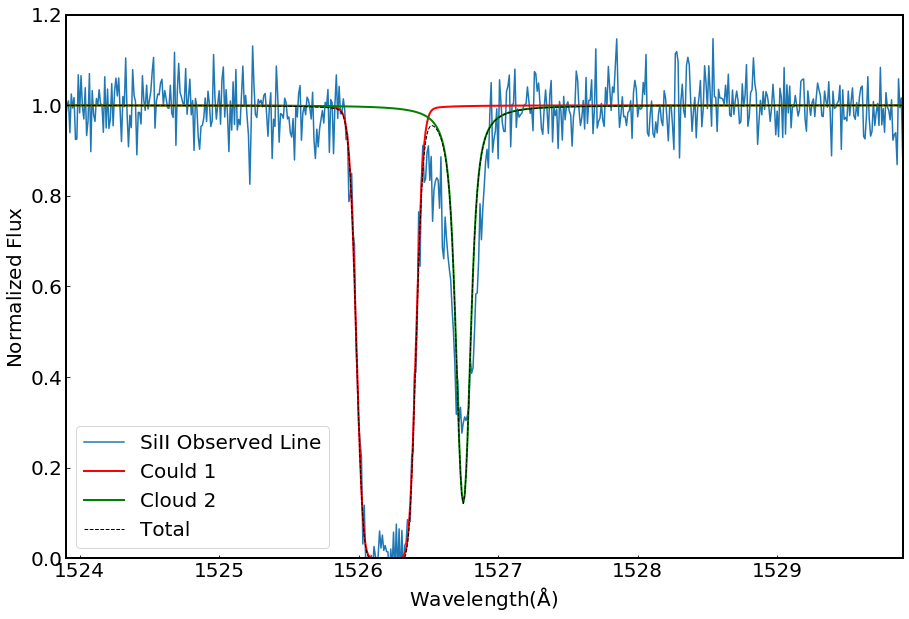

In [39]:
best_values = print_and_plot_results_mc(sampler, wave, fnorm)

samples=sampler.chain[:, 100:, :].reshape((-1, ndim))
st=np.median(samples,axis=0)


for ijk in range(len(st)):
    print("Best value for {:s} is {:16.8f}".format( text_label[ijk],st[ijk]) )
    if(ijk==6):
        print("\n\n")
    

Optimizing Guess ***********
Summary of priors:
  Cloud 0 Summary:
    rho        min/max =     -10.00000000  /        2.00000000  starting value =      -2.64523931
    len        min/max =      10.00000000  /       25.00000000  starting value =      21.84503079
    vel_const  min/max =    -500.00000000  /      500.00000000  starting value =     -10.80550822
    temp       min/max =       1.00000000  /        9.00000000  starting value =       8.97806765
  Cloud 1 Summary:
    rho        min/max =     -10.00000000  /        2.00000000  starting value =      -2.21796656
    len        min/max =      10.00000000  /       25.00000000  starting value =      22.27142937
    vel_const  min/max =    -500.00000000  /      500.00000000  starting value =     -11.00413424
    temp       min/max =       1.00000000  /        9.00000000  starting value =       7.54766856
Starting emcee ***********
Start Burntime Calculations ***********


C:\Users\drewg\Anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Done Burning Steps!  Now starting the Final Calculations:
*****************
[##############################]


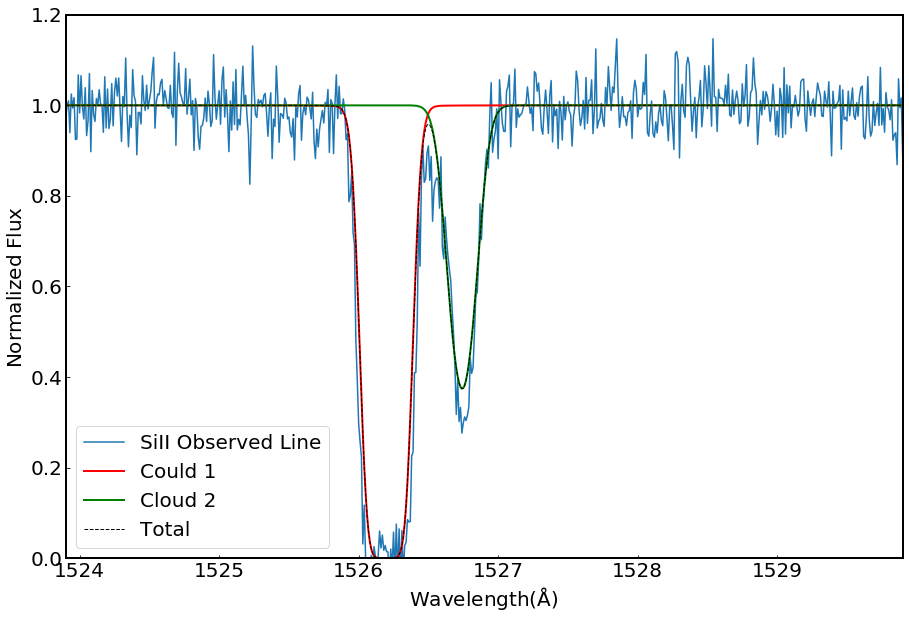

Best value for rho is      -1.60241967
Best value for len is      21.48942176
Best value for vel_const is       8.16125071
Best value for temp is       5.59971553



Best value for rho is      -0.21072662
Best value for len is      20.54428229
Best value for vel_const is     -99.78614461
Best value for temp is       5.83078344
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
[ -2.50098182  21.92410762   7.07610874   5.66719688   0.51206596
  20.05182992 -99.9422963    5.58848278]
[ 2.27266342  2.71525273 17.99151462  1.52859268  1.47622114  1.59644409
  3.75980195  0.24415976]
reduction_values:
[0.18938862 0.18101685 0.01799151 0.19107408 0.12301843 0.10642961
 0.0037598  0.03051997]
Want to reduce search range for index 6 (vel_const)
Summary of priors:
  Cloud 0 Summary:
    rho        min/max =     -10.00000000  /        2.00000000  starting value =      -2.50098182
    len        min/max =      10.00000000  /       25.00000000  starting

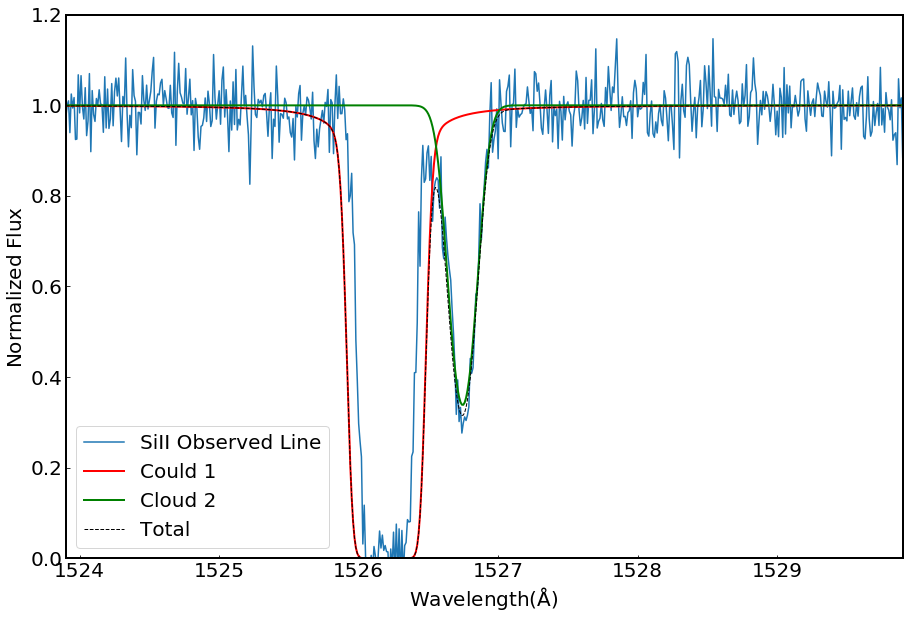

Best value for rho is      -2.01396006
Best value for len is      21.47620154
Best value for vel_const is       7.66770455
Best value for temp is       5.64170411



Best value for rho is      -0.84392702
Best value for len is      22.05696240
Best value for vel_const is     -99.79268601
Best value for temp is       5.55325402
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
[ -5.2051504   24.66023161   7.65398399   5.64265097   0.86248622
  21.44858552 -99.82142357   5.55793268]
[2.17006932 2.16957425 0.27012998 0.01405769 1.70641006 1.68427508
 0.11295256 0.08982225]
reduction_values:
[0.18083911 0.14463828 0.00027013 0.00175721 0.14220084 0.11228501
 0.00300422 0.01122778]
Want to reduce search range for index 2 (vel_const)
Summary of priors:
  Cloud 0 Summary:
    rho        min/max =     -10.00000000  /        2.00000000  starting value =      -5.20515040
    len        min/max =      10.00000000  /       25.00000000  starting value =

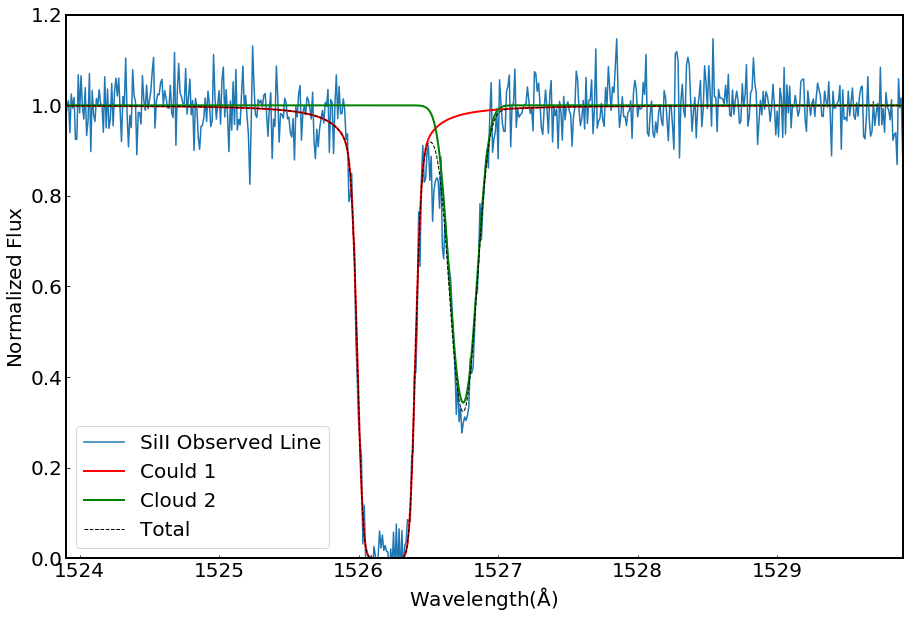

Best value for rho is      -2.03943674
Best value for len is      21.46887253
Best value for vel_const is       8.42180783
Best value for temp is       5.57927666



Best value for rho is      -0.39724876
Best value for len is      22.68213362
Best value for vel_const is     -99.77974551
Best value for temp is       5.26836320
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
[ -3.72189832  23.14162822   8.46363521   5.57583013  -1.74889284
  24.01157196 -99.78320034   5.26660408]
[2.16805669 2.16812195 0.19226582 0.01189888 1.36738729 1.36753544
 0.10654992 0.00657749]
reduction_values:
[0.18067139 0.14454146 0.0711753  0.00148736 0.11394894 0.09116903
 0.00283392 0.00082219]
Want to reduce search range for index 7 (temp)
Summary of priors:
  Cloud 0 Summary:
    rho        min/max =     -10.00000000  /        2.00000000  starting value =      -3.72189832
    len        min/max =      10.00000000  /       25.00000000  starting value =     

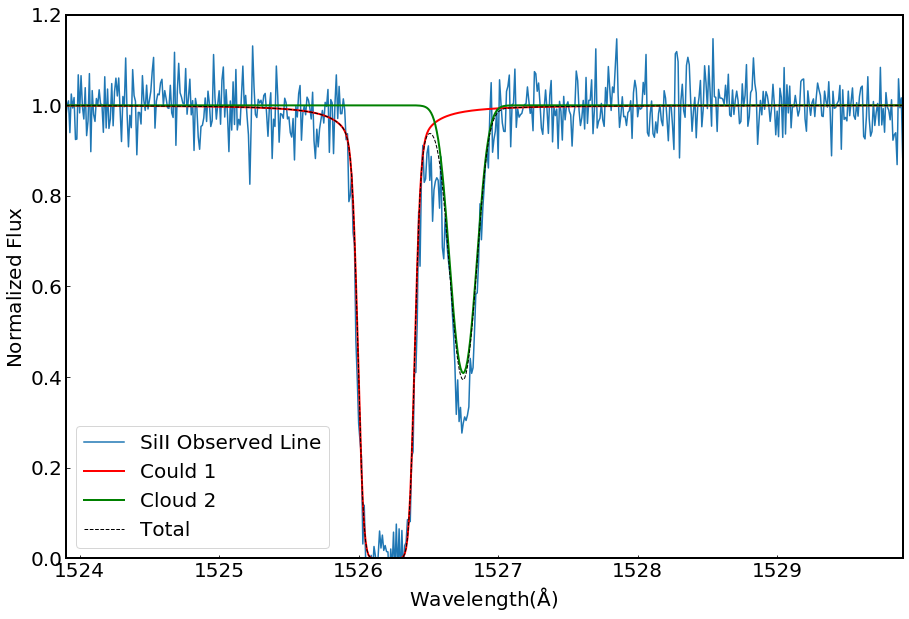

Best value for rho is      -2.07519245
Best value for len is      21.50335754
Best value for vel_const is       8.43911826
Best value for temp is       5.57976186



Best value for rho is      -0.53926174
Best value for len is      22.83004233
Best value for vel_const is     -99.77299480
Best value for temp is       5.26844349
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
[ -3.72172111  23.06695356   8.43956106   5.58280765  -1.74811303
  23.8741468  -99.77281209   5.2683005 ]
[2.15629262 2.15550927 0.18490426 0.02687303 1.35423429 1.35335697
 0.10363485 0.04360317]
reduction_values:
[0.17969105 0.14370062 0.06845011 0.00335913 0.11285286 0.0902238
 0.00275639 0.66291459]
Want to reduce search range for index 6 (vel_const)
Summary of priors:
  Cloud 0 Summary:
    rho        min/max =     -10.00000000  /        2.00000000  starting value =      -3.72172111
    len        min/max =      10.00000000  /       25.00000000  starting value = 

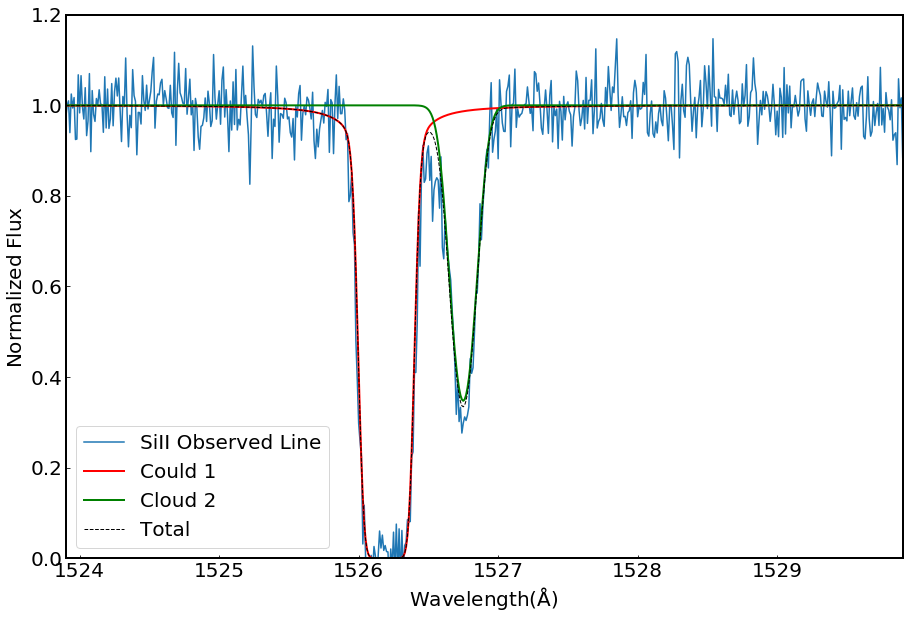

Best value for rho is      -1.91283711
Best value for len is      21.33925043
Best value for vel_const is       8.42426663
Best value for temp is       5.57931339



Best value for rho is      -0.46989592
Best value for len is      22.75271678
Best value for vel_const is     -99.77562025
Best value for temp is       5.26884664
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
[ -3.72623749  23.14305621   8.46897123   5.58074278  -1.74782511
  23.83081828 -99.79972521   5.26819189]
[2.16436757e+00 2.16097182e+00 1.94626526e-01 2.37739071e-02
 1.34696962e+00 1.33882916e+00 1.00000000e+30 4.14735995e-02]
reduction_values:
[1.80363965e-01 1.44064788e-01 7.20492131e-02 2.97173839e-03
 1.12247468e-01 8.92552776e-02 9.64926376e+29 6.30537957e-01]
Want to reduce search range for index 3 (temp)
Summary of priors:
  Cloud 0 Summary:
    rho        min/max =     -10.00000000  /        2.00000000  starting value =      -3.72623749
    len        min/ma

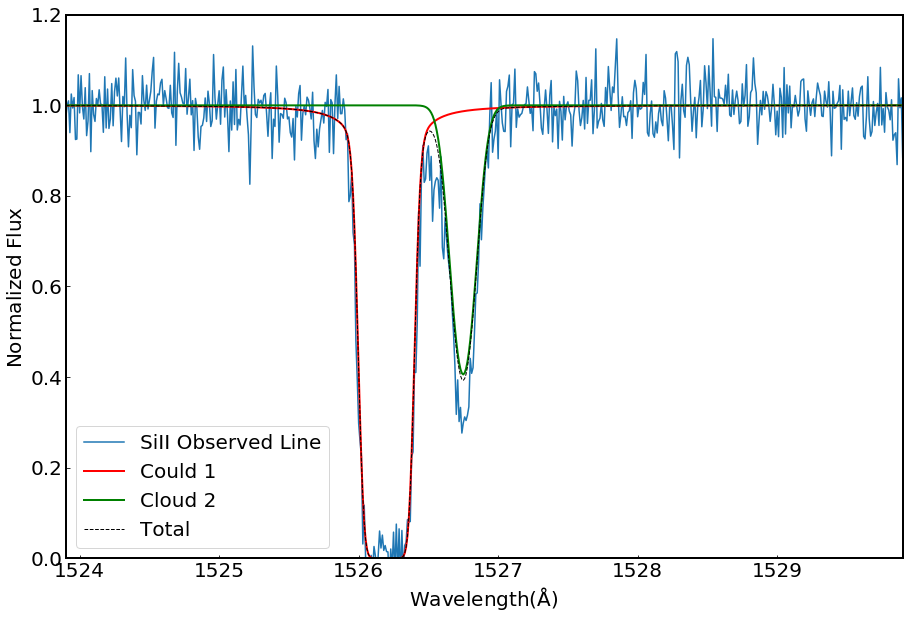

Best value for rho is      -2.06288540
Best value for len is      21.49013138
Best value for vel_const is       8.42473741
Best value for temp is       5.57897631



Best value for rho is      -0.40649281
Best value for len is      22.69217789
Best value for vel_const is     -99.77009951
Best value for temp is       5.26853532
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
[ -3.79646417  23.14282584   8.4151815    5.57763336  -1.79627944
  23.87483207 -99.74804195   5.26950556]
[2.16897223e+00 2.16805713e+00 1.88852575e-01 2.74569789e-02
 1.35943601e+00 1.35233279e+00 1.00000000e+30 4.54856851e-02]
reduction_values:
[1.80747685e-01 1.44537142e-01 6.99117417e-02 1.15492076e-01
 1.13286334e-01 9.01555194e-02 9.64926376e+29 6.91535129e-01]
Want to reduce search range for index 2 (vel_const)
Summary of priors:
  Cloud 0 Summary:
    rho        min/max =     -10.00000000  /        2.00000000  starting value =      -3.79646417
    len        m

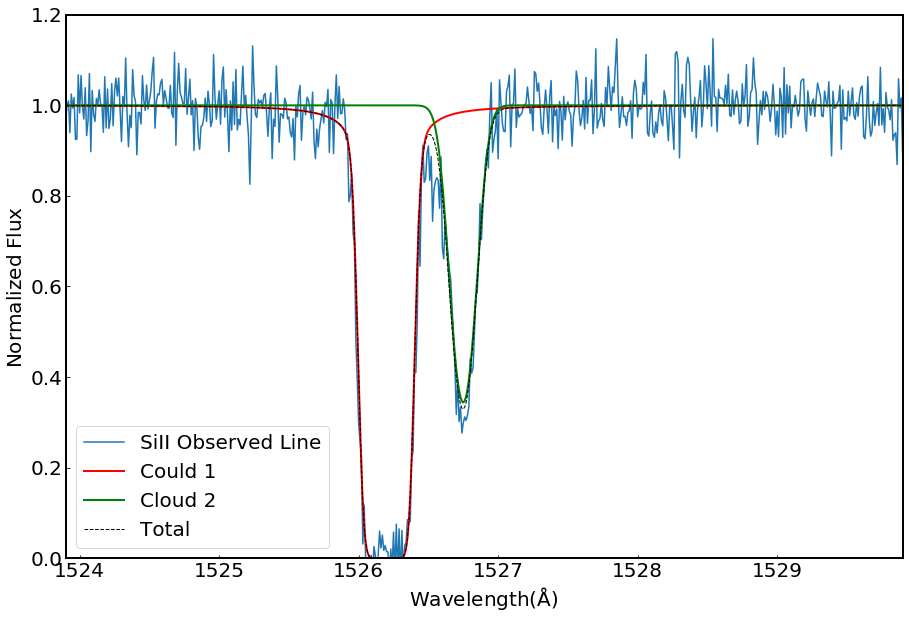

Best value for rho is      -1.99073875
Best value for len is      21.41854144
Best value for vel_const is       8.43002250
Best value for temp is       5.57930542



Best value for rho is      -0.65942701
Best value for len is      22.94359719
Best value for vel_const is     -99.77700342
Best value for temp is       5.26906126
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
[ -3.79800042  23.21876726   8.40658919   5.57988519  -1.74831764
  23.87527406 -99.78981103   5.26884994]
[2.13729630e+00 2.13227442e+00 1.00000000e+30 2.86276742e-02
 1.35987635e+00 1.35065296e+00 1.00000000e+30 5.04073995e-02]
reduction_values:
[1.78108025e-01 1.42151628e-01 5.29513564e+29 1.20416362e-01
 1.13323029e-01 9.00435307e-02 9.64926376e+29 7.66361712e-01]
Want to reduce search range for index 5 (len)
Summary of priors:
  Cloud 0 Summary:
    rho        min/max =     -10.00000000  /        2.00000000  starting value =      -3.79800042
    len        min/max

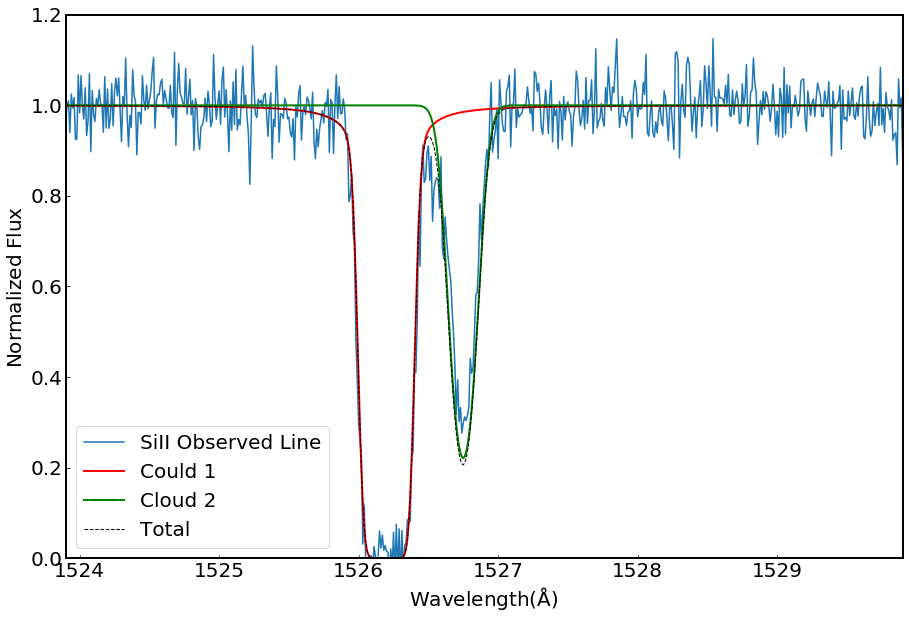

Best value for rho is      -2.13896145
Best value for len is      21.56807512
Best value for vel_const is       8.42112735
Best value for temp is       5.57890301



Best value for rho is      -2.70701441
Best value for len is      24.99495366
Best value for vel_const is     -99.77627144
Best value for temp is       5.26849312
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
(150000, 8)
[ -3.79738483  23.36934763   8.42374045   5.57941387  -1.69431696
  23.82451653 -99.80843424   5.26915738]
[2.18281543e+00 2.18544461e+00 1.00000000e+30 3.78717891e-02
 2.88211546e+00 2.88620348e+00 1.00000000e+30 4.56948798e-02]
reduction_values:
[1.81901286e-01 1.45696307e-01 5.29513564e+29 1.59299811e-01
 2.40176288e-01 2.13689494e-01 9.64926376e+29 6.94715591e-01]
Want to reduce search range for index 1 (len)


In [40]:
perturbation=1e-1
no_of_Chain=250
no_of_steps=750

n_components = 2

rho    = 1e-3           # a semi-typical CGM density
loc_cm = 3.086e+21      # a kpc
solar  =1.05
f_c    = 0.5
vel_const = 0.
temp   =3e5
initial_beta_guess = [np.log10(rho), np.log10(loc_cm), vel_const, np.log10(temp) ]


beta       = np.concatenate((initial_beta_guess,initial_beta_guess))
text_label = ['rho', 'len', 'vel_const', 'temp', 
              'rho', 'len', 'vel_const', 'temp' ]
lb_multi   = np.concatenate((lb,lb))
ub_multi   = np.concatenate((ub,ub))

length_of_lb = len(lb_multi)
ndim, nwalkers = length_of_lb, no_of_Chain

print('Optimizing Guess ***********')
initial_beta_guess = optimize_guess(multi_component_model_guess, beta, lb_multi, ub_multi, wave, fnorm, enorm)

#guesses = np.array([initial_beta_guess + perturbation * np.random.randn(ndim) for i in range(nwalkers)])

restricted = np.zeros_like( lb_multi )

for ijk in range(8):
    print("Summary of priors:")
    for ijk in range(len(lb_multi)):
        if (ijk%4==0):
            print("  Cloud {:d} Summary:".format( np.rint(ijk/7).astype(np.int) ) )
        print("    {:10s} min/max = {:16.8f}  /  {:16.8f}  starting value = {:16.8f}".format(text_label[ijk], lb_multi[ijk],ub_multi[ijk], initial_beta_guess[ijk])  )



    guesses = np.array([initial_beta_guess + perturbation * np.random.randn(ndim) for i in range(nwalkers)])



    print("Starting emcee ***********")
    burntime = np.round(no_of_steps * .2)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=32,
                                args=(lb_multi, ub_multi, multi_component_model_guess, wave, fnorm, enorm))
    print("Start Burntime Calculations ***********")

    pos, prob, state = sampler.run_mcmc(guesses, burntime) #First Burning some steps
    sampler.reset()

    print("Done Burning Steps!  Now starting the Final Calculations:")
    print("*****************")
    #Now Running mcmc
    for i, result in enumerate(sampler.sample(pos, iterations=no_of_steps)):
        n = int((width+1) * float(i) / no_of_steps)
        sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
    sys.stdout.write("\n")
    
    best_values = print_and_plot_results_mc(sampler, wave, fnorm)
    plt.show()

    samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))
    st=np.median(samples,axis=0)

    for ijk in range(len(st)):
        print("Best value for {:s} is {:16.8f}".format( text_label[ijk],st[ijk]) )
        if(ijk==3):
            print("\n\n")
            
    for param_index in range(8):
        print(np.array(samples).shape)
        hist,edges = np.histogram(samples[:,param_index], bins=100)
        edges = (edges[:-1] + edges[1:])/2.0
        st[param_index] = edges[np.argmax(hist)] 
#    st   =np.median(samples,axis=0)
    stdev=np.std(samples,axis=0)
    stdev[ restricted == 2 ] = 1e30
    initial_beta_guess = st
    print(initial_beta_guess)
    print(stdev)
    
    reduction_values = stdev / (ub_multi - lb_multi)
    print("reduction_values:")
    print(reduction_values)
    index_to_reduce = np.argmin( reduction_values )
    print("Want to reduce search range for index {:d} ({:s})".format(index_to_reduce, text_label[index_to_reduce]) )
    
    
    lb_multi[index_to_reduce] = initial_beta_guess[index_to_reduce] - 5.0*stdev[index_to_reduce]
    ub_multi[index_to_reduce] = initial_beta_guess[index_to_reduce] + 5.0*stdev[index_to_reduce]
    
    restricted[index_to_reduce] += 1

In [41]:
#make_corner_plots_mc(sampler)

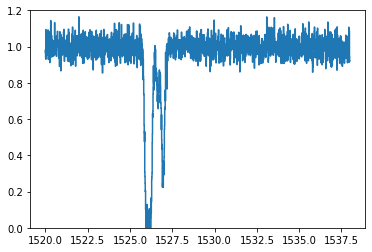

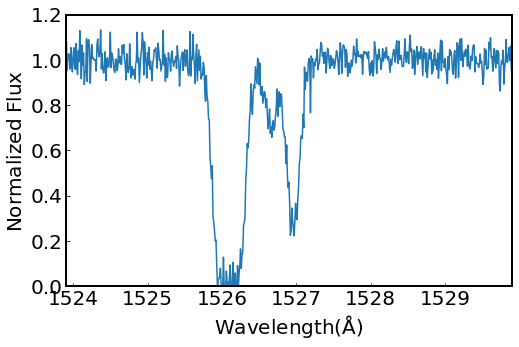

In [42]:
# We are setting up 3 clumps at z = 0
# For SiII 1526 absorption
# With default 6.5 pixel FWHM of HST/COS and Gaussian convolution
n_clouds = 3
zabs=np.zeros((n_clouds))
lambda_rest = 1526.9 * np.ones((n_clouds))
s=m.create_voigt(zabs,lambda_rest)

#Properties of the lines (column density, dopler b, velocity)
logN=np.array([14.,13.5, 15.])
b=np.array(   [20.,21.,29.])
v=np.array(   [50.,-10.,-120.])
theta=np.concatenate((logN,b,v))

outflux= s.model_flux(theta,wave)
orig_values = np.array([logN, b, v])

# Add error
fnorm= outflux + np.random.normal(0., .05, len(wave))
enorm= 0.02 * np.ones((len(wave),))

plt.step(wave,fnorm)
plt.ylim([0.,1.2])


fig, ax = plt.subplots(figsize=(8, 5))
    
ax.plot(wave,fnorm, label='Observed Si II Line')
#ax.legend(fontsize=20)
ax.set_xlim([np.mean(lambda_rest)-3, np.mean(lambda_rest)+3])
ax.set_ylim([0.,1.2])
ax.set_ylabel(r'$\mathrm{Normalized\;Flux}$')
ax.set_xlabel(r'$\mathrm{Wavelength (\AA)}$')
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)
    #plt.gcf().

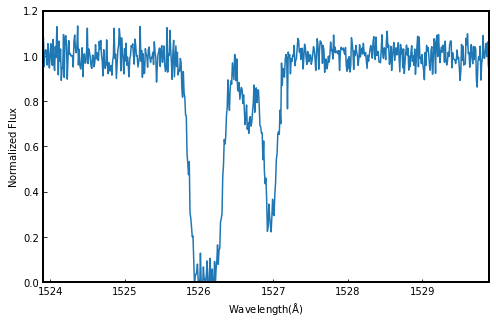

In [44]:
fig, ax = plt.subplots(figsize=(8, 5))
    
ax.plot(wave,fnorm, label='Mock Data')
ax.set_xlim([np.mean(lambda_rest)-3, np.mean(lambda_rest)+3])
ax.set_ylim([0.,1.2])
ax.set_ylabel(r'$\mathrm{Normalized\;Flux}$')
ax.set_xlabel(r'$\mathrm{Wavelength (\AA)}$')
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)


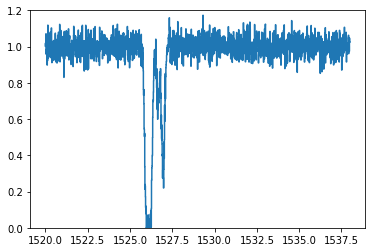

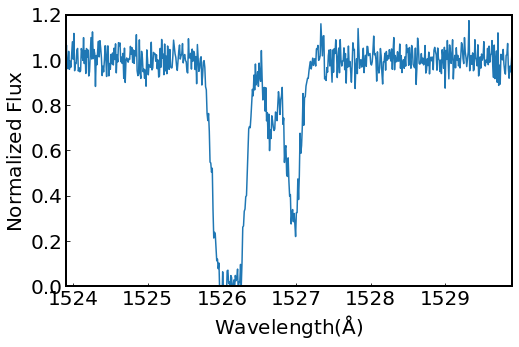

In [48]:
wave=np.arange(1520.,1538.,0.01)
# We are setting up 3 clumps at z = 0
# For SiII 1526 absorption
# With default 6.5 pixel FWHM of HST/COS and Gaussian convolution
n_clouds = 3
zabs=np.zeros((n_clouds))
lambda_rest = 1526.9 * np.ones((n_clouds))
s=m.create_voigt(zabs,lambda_rest)

#Properties of the lines (column density, dopler b, velocity)
logN=np.array([14.,13.5, 15.])
b=np.array(   [20.,21.,29.])
v=np.array(   [50.,-10.,-120.])
theta=np.concatenate((logN,b,v))

outflux= s.model_flux(theta,wave)
orig_values = np.array([logN, b, v])

# Add error
fnorm= outflux + np.random.normal(0., .05, len(wave))
enorm= 0.02 * np.ones((len(wave),))

plt.step(wave,fnorm)
plt.ylim([0.,1.2])


fig, ax = plt.subplots(figsize=(8, 5))
    
ax.plot(wave,fnorm, label='Observed Si II Line')
#ax.legend(fontsize=20)
ax.set_xlim([np.mean(lambda_rest)-3, np.mean(lambda_rest)+3])
ax.set_ylim([0.,1.2])
ax.set_ylabel(r'$\mathrm{Normalized\;Flux}$')
ax.set_xlabel(r'$\mathrm{Wavelength (\AA)}$')
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)
    #plt.gcf().

In [50]:
gN_, b_, vel_p_= estimate_parameter_single_cell(beta[0], beta[1], beta[2], beta[3])
print("Current Starting Position (logN,b,vel_p): ({:8.4f},{:8.4f},{:8.4f})".format(logN_,b_,vel_p_))
print("Input values were (logN,b,v): ({:8.4f},{:8.4f},{:8.4f})".format(orig_values.flatten()[0],orig_values.flatten()[1],orig_values.flatten()[2]))

print('Optimizing Guess ***********')
popt = optimize_guess(model_guess, beta, lb, ub, wave, fnorm_1, enorm)

######
guesses = [popt + perturbation * np.random.randn(ndim) for i in range(nwalkers)]
print("Starting emcee ***********")
burntime = np.round(no_of_steps * .2)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=32, args=(lb, ub, model_guess, wave, fnorm_1, enorm))
print("Start Burntime Calculations ***********")

pos, prob, state = sampler.run_mcmc(guesses, burntime)     #First Burning some steps
sampler.reset()

print("Done Burning Steps!  Now starting the Final Calculations:")
for i, result in enumerate(sampler.sample(pos, iterations=no_of_steps)):
    n = int((width+1) * float(i) / no_of_steps)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
sys.stdout.write("\n")

cloud1_best_fit = print_and_plot_results(sampler, wave, fnorm_1)



Current Starting Position (logN,b,vel_p): ( 13.0294, 18.8768,  0.0000)
Input values were (logN,b,v): ( 14.0000, 13.5000, 15.0000)
Optimizing Guess ***********


ValueError: operands could not be broadcast together with shapes (4,) (8,) 